### Import statements

In [139]:
# enter the desired folder
%cd CloMu-main
%ls

import os
import numpy as np
import CloMu
import matplotlib.pyplot as plt
import random as rd

[Errno 2] No such file or directory: 'CloMu-main'
/Users/paolobresolin/Desktop/current working directory/code/CloMu-main
CloMu.py           Models/            analysis.py        overview.png
Demo.md            README.md          data/              results/
LICENSE            __pycache__/       overview-crop.png  script.py


### Constants

In [158]:
# number of trees to be included in the same test set for all models
N = 2000

# number of trees to be included in the training set for all models
TRAIN_SIZE = 2000

### Paths

In [141]:
# path to the current directory
current_dir = os.getcwd()

# create the folder where to store the training results
results_rem = os.path.join(current_dir, "..", "results_rem")
if not os.path.exists(results_rem):
    os.mkdir(results_rem)
    print("Directory" + " results_rem " + "created successfully.")
else:
    print("Directory" + " results_rem " + "already exists.")

# create the folder where to store the dataset
dataset_folder = os.path.join(results_rem, "datasets")
if not os.path.exists(dataset_folder):
    os.mkdir(dataset_folder)
    print("Directory" + " datasets " + "created successfully.")
else:
    print("Directory" + " datasets " + "already exists.")

# path to the input file for training
input_file_breast = os.path.join(current_dir, "data", "realData", "breastCancer.npy")

# path to the file where to store mutation names
mutationFile = os.path.join(results_rem, "mutationNamesBreastCancerRemoval.npy")

Directory results_rem already exists.
Directory datasets already exists.


### Utility functions

In [142]:
# Given dataset, it removes all trees longer than max_length. Then it saves the obtained dataset in path.
# max_length: maximum length of a tree, i.e., maximum number of different mutations a tree can contain.
# dataset: input dataset to process. It is a numpy array of lists. Each list is a patient and it is represented
#          as a list of trees. Given a patient, all associated trees have the same length. A tree is a list of edges.
# path: path where to save the obtained dataset. The dataset is saved as a .npy file with trees stored with the same
#       format of dataset.
# The function returns the created dataset as a numpy array.
def remove_long_trees(max_length, dataset, path):
    
    # create a new numpy array with the same size of dataset
    new_dataset = np.empty(shape=dataset.shape, dtype="object")
    # number of patients added to new_dataset so far
    number_added_patients = 0

    # iterate over the patients in the dataset
    for patient in dataset:

        # length of the trees associated with the current patient
        trees_length = len(patient[0])

        # save the patient in the new dataset only if it is not longer than max_length
        if trees_length <= max_length:
            new_dataset[number_added_patients] = patient
            number_added_patients += 1
        
    # reshape the numpy array so that it contains all and only the added patients
    new_dataset = new_dataset[:number_added_patients]

    # save the dataset as a .npy file
    np.save(path, new_dataset)

    # return the dataset
    return new_dataset

In [143]:
# Function that, given an input dataset, returns a shuffled version of it.
# input_dataset: the dataset to be shuffled.
# path: path where to save the obtained dataset. The dataset is saved as a .npy file with trees stored with the same
#       format of input_dataset.
# seed: random seed used to allow for reproducibility.
# Returns a shuffled version of input_dataset.
def shuffle_dataset(input_dataset, path, seed):

    # generate a permutation of the indices in input_dataset
    indices = [i for i in range(len(input_dataset))]
    rd.seed(seed)
    rd.shuffle(indices)

    # create a shuffled version of the dataset according to the permutation of indices
    shuffled_dataset = np.empty(shape=input_dataset.shape, dtype="object")

    for i in range(len(indices)):
        shuffled_dataset[i] = input_dataset[indices[i]]
    
    # save the dataset as a .npy file
    np.save(path, shuffled_dataset)
    
    return shuffled_dataset

In [144]:
# Remove the patient with the largest number of trees in dataset from the dataset itself.
# dataset: dataset from which the patient has to be removed.
# Returns the dataset without the patient with the largest number of trees and the patient itself.
def remove_largest_patient(dataset):

    # find the patient with more trees
    index = 0
    max = 0
    for i in range(len(dataset)):
        if len(dataset[i]) > max:
            max = len(dataset[i])
            index = i
    
    # remove the patient from the dataset and return the new dataset
    if index == len(dataset) - 1:
        return dataset[:-1], dataset[-1]
    return np.concatenate((dataset[:index], dataset[index + 1:])), dataset[index]

In [145]:
# Splits the input dataset into two subsets, where one of them contains patients with a total of n trees approximately.
# dataset: input dataset to be split.
# n: number of trees that one of the two sets should approximately contain.
# Returns two sets, one of them with more or less n trees.
def split_two_n(dataset, n):

    # the two subsets to be returned, where set_n will contain almost n trees
    set_0 = []
    set_n = []

    # fill set_n until it has more or less n trees
    contained_trees = 0
    patients_ids = []
    for i in range(len(dataset)):
        if len(dataset[i]) + contained_trees <= n:
            set_n.append(dataset[i])
            patients_ids.append(i)
            contained_trees += len(dataset[i])
        if contained_trees >= n:
            break
    
    # fill set_0 with all patients that are in dataset, but not in set_n
    set_0 = [dataset[i] for i in range(len(dataset)) if i not in patients_ids]
    
    return np.array(set_0, dtype=object), np.array(set_n, dtype=object)

### Pre-processing and patient extraction

We remove too long trees from the dataset as a pre-processing step and then we extract the patient with the largest number of trees from the dataset itself.

In [146]:
# maximum number of mutations allowed for each tree, i.e., maximum tree length
maxM = 9

# load the original dataset as a numpy array
treeData = np.load(input_file_breast, allow_pickle=True)

# remove too long trees
treeData = remove_long_trees(maxM, treeData, os.path.join(dataset_folder, "processed_breast_dataset.npy"))

# remove the patient with more trees
treeData, largest_patient = remove_largest_patient(treeData)

# save the extracted patient
np.save(os.path.join(dataset_folder, "largest_patient.npy"), largest_patient)

# print the number of trees contained by the extracted patient
print("The patient removed from the dataset has " + str(len(largest_patient)) + " trees.")

The patient removed from the dataset has 970 trees.


### Extract the test set

We want to extract a test set of about N trees such that we can evaluate all the models we will train on it.

In [147]:
# Set a random seed to allow for reproducibility
RANDOM_SEED = 8

# path where to store the shuffled dataset
shuffled_dataset_file = os.path.join(dataset_folder, "shuffled_breast_dataset.npy")
# shuffle the dataset
treeData = shuffle_dataset(treeData, shuffled_dataset_file, RANDOM_SEED)

# exctract a test set from treeData with more or less N trees
treeData, test_set = split_two_n(treeData, N)

Check the sizes of the obtained sets.

In [148]:
# compute the number of trees in the extracted test set and in the other set
n_trees_test = 0
for patient in test_set:
    n_trees_test += len(patient)

n_trees_treeData = 0
for patient in treeData:
    n_trees_treeData += len(patient)

# print the results
print("The extracted test set consists of " + str(len(test_set)) + " patients, with a total of " + str(n_trees_test) + " trees.")
print("The other set consists of " + str(len(treeData)) + " patients, with a total of " + str(n_trees_treeData) + " trees.")

The extracted test set consists of 630 patients, with a total of 2000 trees.
The other set consists of 593 patients, with a total of 2651 trees.


Check what is the maximum size of patients in the two trees.

In [149]:
# find the patient with the largest number of trees in the training set
max_test = 0
max_i_test = 0
for i in range(len(test_set)):
    if len(test_set[i]) > max_test:
        max_test = len(test_set[i])
        max_i_test = i
print("Patient " + str(max_i_test) + " is the patient in the test set with the largest number of trees, that is " + str(max_test) + ".")

# find the patient with the largest number of trees in the other set
max_treeData = 0
max_i_treeData = 0
for i in range(len(treeData)):
    if len(treeData[i]) > max_treeData:
        max_treeData = len(treeData[i])
        max_i_treeData = i
print("Patient " + str(max_i_treeData) + " is the patient in the training set with the largest number of trees, that is " + str(max_treeData) + ".")

Patient 497 is the patient in the test set with the largest number of trees, that is 296.
Patient 197 is the patient in the training set with the largest number of trees, that is 406.


Save the two subsets as two different files.

In [150]:
# save the two datasets as separate files
np.save(os.path.join(dataset_folder, "test_set.npy"), test_set)
np.save(os.path.join(dataset_folder, "dataset_after_removal.npy"), treeData)

# Seed 27

### Random seed

In [151]:
# Set a random seed to allow for reproducibility
RANDOM_SEED = 27

### Paths

In [152]:
# create the folders where to store the training results with this seed
results_27 = os.path.join(results_rem, "seed_27")
if not os.path.exists(results_27):
    os.mkdir(results_27)
    print("Directory" + " seed_27 " + "created successfully.")
else:
    print("Directory" + " seed_27 " + "already exists.")

results_27_complete = os.path.join(results_27, "results_complete")
if not os.path.exists(results_27_complete):
    os.mkdir(results_27_complete)
    print("Directory" + " results_complete " + "created successfully.")
else:
    print("Directory" + " results_complete " + "already exists.")

results_27_removal = os.path.join(results_27, "results_removal")
if not os.path.exists(results_27_removal):
    os.mkdir(results_27_removal)
    print("Directory" + " results_removal " + "created successfully.")
else:
    print("Directory" + " results_removal " + "already exists.")

datasets_27 = os.path.join(results_27, "datasets")
if not os.path.exists(datasets_27):
    os.mkdir(datasets_27)
    print("Directory" + " datasets " + "created successfully.")
else:
    print("Directory" + " datasets " + "already exists.")

Directory seed_27 already exists.
Directory results_complete already exists.
Directory results_removal already exists.
Directory datasets already exists.


### Pre-processing

We do the following steps:
- shuffle treeData using the new random seed;
- split the treeData into a training set with more or less 2000 trees and a test set with the remaining patients;
- add the patient previously removed to the training set;
- save two datasets: the complete one and the reduced version.

In [159]:
# shuffle the dataset
treeData_27_reduced = shuffle_dataset(treeData, os.path.join(datasets_27, "shuffled_dataset.npy"), RANDOM_SEED)

# split the dataset into training set and test set
test_set_27, training_set_27_reduced = split_two_n(treeData_27_reduced, TRAIN_SIZE)

# add the patient previously removed to the training set
training_set_27_complete = [patient for patient in training_set_27_reduced]
training_set_27_complete.append(largest_patient)
training_set_27_complete = np.array(training_set_27_complete, dtype=object)

# print some information regarding the number of patients in each set
print("Total number of patients in the dataset: " + str(len(treeData_27_reduced)))
print("Number of patients in the training set: " + str(len(training_set_27_reduced)))
print("Number of patients in the test set: " + str(len(test_set_27)))
print("Number of patients in the training set (plus removed ones): " + str(len(training_set_27_complete)))
print()


# compute the number of trees in each set
n_trees_27_reduced = 0
for patient in treeData_27_reduced:
    n_trees_27_reduced += len(patient)

n_trees_training_27_reduced = 0
for patient in training_set_27_reduced:
    n_trees_training_27_reduced += len(patient)

n_trees_training_27_complete = 0
for patient in training_set_27_complete:
    n_trees_training_27_complete += len(patient)

n_trees_test_27 = 0
for patient in test_set_27:
    n_trees_test_27 += len(patient)

# print some information regarding the number of trees in each set
print("Total number of trees in the dataset: " + str(n_trees_27_reduced))
print("Number of trees in the training set: " + str(n_trees_training_27_reduced))
print("Number of trees in the test set: " + str(n_trees_test_27))
print("Number of trees in the training set (plus removed ones): " + str(n_trees_training_27_complete))
print()

# save the dataset with the extracted patient
dataset_27_complete = np.concatenate((training_set_27_complete, test_set_27, test_set))
np.save(os.path.join(datasets_27, "dataset_27_complete.npy"), dataset_27_complete)
# save the dataset without the extracted patient
dataset_27_reduced = np.concatenate((training_set_27_reduced, test_set_27, test_set))
np.save(os.path.join(datasets_27, "dataset_27_reduced.npy"), dataset_27_reduced)

# print some information about the datasets
n_dataset_27_complete = 0
for patient in dataset_27_complete:
    n_dataset_27_complete += len(patient)

print("CONSTRUCTED DATASETS")
print("Total number of patients in the dataset with the extracted patient: " + str(len(dataset_27_complete)))
print("Total number of trees in the dataset with the extracted patient: " + str(n_dataset_27_complete))

n_dataset_27_reduced = 0
for patient in dataset_27_reduced:
    n_dataset_27_reduced += len(patient)

print("Total number of patients in the dataset without the extracted patient: " + str(len(dataset_27_reduced)))
print("Total number of trees in the dataset without the extracted patient: " + str(n_dataset_27_reduced))

Total number of patients in the dataset: 593
Number of patients in the training set: 426
Number of patients in the test set: 167
Number of patients in the training set (plus removed ones): 427

Total number of trees in the dataset: 2651
Number of trees in the training set: 2000
Number of trees in the test set: 651
Number of trees in the training set (plus removed ones): 2970

CONSTRUCTED DATASETS
Total number of patients in the dataset with the extracted patient: 1224
Total number of trees in the dataset with the extracted patient: 5621
Total number of patients in the dataset without the extracted patient: 1223
Total number of trees in the dataset without the extracted patient: 4651


### Training with patient

In [162]:
# training a CloMu model on all the patients in the training set, including the one with 970 trees
!python3 CloMu.py train raw ./../results_rem/seed_27/datasets/dataset_27_complete.npy ./../results_rem/seed_27/results_complete/model_complete_27.pt ./../results_rem/seed_27/results_complete/trees_probabilities_breast_27_complete.npy ./../results_rem/seed_27/results_complete/mutationNamesBreastCancer27.npy 9 -trainSize 427 -iter 1000 -verbose

The code runs for 1000 iterations.
The user can stop the code at any time if the testing loss has 
converged sufficiently close to the optimum for the user's applicaiton. 
iteration 0 of 1000

Mean Probability:  1.781575041882943e-08
Training Score:  -27.820798445665996 Testing Score: -27.712812103432622
Loss:  4.493267611269569
iteration 1 of 1000

Mean Probability:  8.462448336671965e-08
Training Score:  -25.92652575073599 Testing Score: -25.87988078868732
Loss:  3.706554287155167
iteration 2 of 1000

Mean Probability:  3.0610162962601045e-07
Training Score:  -24.701094549402722 Testing Score: -24.677152239595337
Loss:  3.0432120083739744
iteration 3 of 1000

Mean Probability:  1.634517442593367e-06
Training Score:  -23.581491106732447 Testing Score: -23.622258232855255
Loss:  2.621547914487716
iteration 4 of 1000

Mean Probability:  8.992489505530404e-06
Training Score:  -22.755886023646305 Testing Score: -22.803829307931895
Loss:  2.051736068083943
iteration 5 of 1000

Mean Probabi

### Training without patient

In [163]:
# training a CloMu model on the patients in the training set, but without the one with 970 trees
!python3 CloMu.py train raw ./../results_rem/seed_27/datasets/dataset_27_reduced.npy ./../results_rem/seed_27/results_removal/model_reduced_27.pt ./../results_rem/seed_27/results_removal/trees_probabilities_breast_27_reduced.npy ./../results_rem/seed_27/results_removal/mutationNamesBreastCancer27.npy 9 -trainSize 426 -iter 1000 -verbose

The code runs for 1000 iterations.
The user can stop the code at any time if the testing loss has 
converged sufficiently close to the optimum for the user's applicaiton. 
iteration 0 of 1000

Mean Probability:  2.004326983668729e-08
Training Score:  -27.86304652319015 Testing Score: -27.76359640232723
Loss:  6.5965193151709425
iteration 1 of 1000

Mean Probability:  1.9006888927707673e-07
Training Score:  -25.49016058871534 Testing Score: -25.38884572988438
Loss:  5.446378226191197
iteration 2 of 1000

Mean Probability:  3.994639843299286e-06
Training Score:  -23.54433635866468 Testing Score: -23.531772475870408
Loss:  4.498836602402684
iteration 3 of 1000

Mean Probability:  2.917480287861489e-05
Training Score:  -22.680106863517093 Testing Score: -22.69472838231109
Loss:  2.9699741335342997
iteration 4 of 1000

Mean Probability:  3.571570497448329e-05
Training Score:  -22.08081494629899 Testing Score: -22.149095334957302
Loss:  2.799873788332773
iteration 5 of 1000

Mean Probability

### Comparison

COMPLETE
Max probability: 0.02415109438907713
Min probability: 2.5353784726852314e-30
Mean probability: 0.0001162380225373745
Median probability: 2.9493575625932253e-19

REDUCED
Max probability: 0.015899228884029427
Min probability: 7.581476853059857e-30
Mean probability: 0.00014250362519314626
Median probability: 5.279390478210684e-17


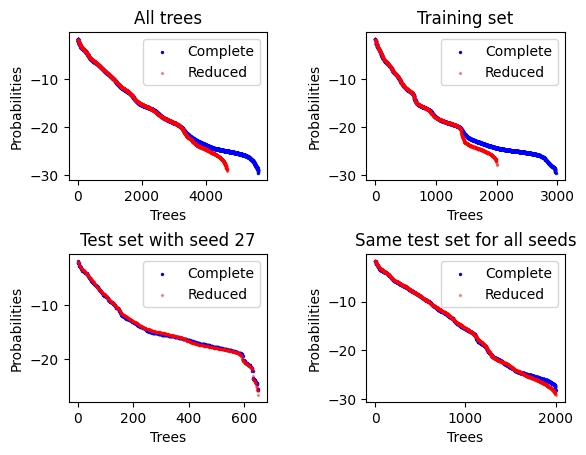

In [176]:
# load the probabilities
prob_27_complete = np.load(os.path.join(results_27_complete, "trees_probabilities_breast_27_complete.npy"))
prob_27_reduced = np.load(os.path.join(results_27_removal, "trees_probabilities_breast_27_reduced.npy"))

# split the probailities based on the set to which the related trees belong
prob_27_complete_train = prob_27_complete[:n_trees_training_27_complete]
prob_27_complete_test_27 = prob_27_complete[n_trees_training_27_complete:n_trees_training_27_complete + n_trees_test_27]
prob_27_complete_test_same = prob_27_complete[n_trees_training_27_complete + n_trees_test_27:]

prob_27_reduced_train = prob_27_reduced[:n_trees_training_27_reduced]
prob_27_reduced_test_27 = prob_27_reduced[n_trees_training_27_reduced:n_trees_training_27_reduced + n_trees_test_27]
prob_27_reduced_test_same = prob_27_reduced[n_trees_training_27_reduced + n_trees_test_27:]

# print some statistics
print("COMPLETE")
print("Max probability: " + str(np.max(prob_27_complete)))
print("Min probability: " + str(np.min(prob_27_complete)))
print("Mean probability: " + str(np.mean(prob_27_complete)))
print("Median probability: " + str(np.median(prob_27_complete)))
print()
print("REDUCED")
print("Max probability: " + str(np.max(prob_27_reduced)))
print("Min probability: " + str(np.min(prob_27_reduced)))
print("Mean probability: " + str(np.mean(prob_27_reduced)))
print("Median probability: " + str(np.median(prob_27_reduced)))
# print("COMPLETE")
# print()
# print("TRAINING SET")
# print("Max probability: " + str(np.max(prob_27_complete_train)))
# print("Min probability: " + str(np.min(prob_27_complete_train)))
# print("Mean probability: " + str(np.mean(prob_27_complete_train)))
# print("Median probability: " + str(np.median(prob_27_complete_train)))
# print()
# print("TEST SET")
# print("Max probability: " + str(np.max(prob_27_complete_test_same)))
# print("Min probability: " + str(np.min(prob_27_complete_test_same)))
# print("Mean probability: " + str(np.mean(prob_27_complete_test_same)))
# print("Median probability: " + str(np.median(prob_27_complete_test_same)))
# print()
# print("REDUCED")
# print()
# print("TRAINING SET")
# print("Max probability: " + str(np.max(prob_27_reduced_train)))
# print("Min probability: " + str(np.min(prob_27_reduced_train)))
# print("Mean probability: " + str(np.mean(prob_27_reduced_train)))
# print("Median probability: " + str(np.median(prob_27_reduced_train)))
# print()
# print("TEST SET")
# print("Max probability: " + str(np.max(prob_27_reduced_test_same)))
# print("Min probability: " + str(np.min(prob_27_reduced_test_same)))
# print("Mean probability: " + str(np.mean(prob_27_reduced_test_same)))
# print("Median probability: " + str(np.median(prob_27_reduced_test_same)))

# sort the probabilities in non-decreasing order
sorted_prob_27_complete = np.sort(prob_27_complete)[::-1]
sorted_prob_27_complete_train = np.sort(prob_27_complete_train)[::-1]
sorted_prob_27_complete_test_27 = np.sort(prob_27_complete_test_27)[::-1]
sorted_prob_27_complete_test_same = np.sort(prob_27_complete_test_same)[::-1]

sorted_prob_27_reduced = np.sort(prob_27_reduced)[::-1]
sorted_prob_27_reduced_train = np.sort(prob_27_reduced_train)[::-1]
sorted_prob_27_reduced_test_27 = np.sort(prob_27_reduced_test_27)[::-1]
sorted_prob_27_reduced_test_same = np.sort(prob_27_reduced_test_same)[::-1]

# plot each corresponding pair of sorted arrays in order to compare performances of the two models
figure, ((axis_all, axis_train), (axis_test_27, axis_test_same)) = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# all trees
axis_all.set_title("All trees")
axis_all.set_xlabel("Trees")
axis_all.set_ylabel("Probabilities")
axis_all.scatter([i for i in range(len(sorted_prob_27_complete))], np.log10(sorted_prob_27_complete), label='Complete', marker='o', color='blue', s=2)
axis_all.scatter([i for i in range(len(sorted_prob_27_reduced))], np.log10(sorted_prob_27_reduced), label='Reduced', marker='x', color='red', s=2, alpha=0.5)
axis_all.legend()

# training set
axis_train.set_title("Training set")
axis_train.set_xlabel("Trees")
axis_train.set_ylabel("Probabilities")
axis_train.scatter([i for i in range(len(sorted_prob_27_complete_train))], np.log10(sorted_prob_27_complete_train), label='Complete', marker='o', color='blue', s=2)
axis_train.scatter([i for i in range(len(sorted_prob_27_reduced_train))], np.log10(sorted_prob_27_reduced_train), label='Reduced', marker='x', color='red', s=2, alpha=0.5)
axis_train.legend()

# test set with seed 27
axis_test_27.set_title("Test set with seed 27")
axis_test_27.set_xlabel("Trees")
axis_test_27.set_ylabel("Probabilities")
axis_test_27.scatter([i for i in range(len(sorted_prob_27_complete_test_27))], np.log10(sorted_prob_27_complete_test_27), label='Complete', marker='o', color='blue', s=2)
axis_test_27.scatter([i for i in range(len(sorted_prob_27_reduced_test_27))], np.log10(sorted_prob_27_reduced_test_27), label='Reduced', marker='x', color='red', s=2, alpha=0.5)
axis_test_27.legend()

# same test set for all seeds
axis_test_same.set_title("Same test set for all seeds")
axis_test_same.set_xlabel("Trees")
axis_test_same.set_ylabel("Probabilities")
axis_test_same.scatter([i for i in range(len(sorted_prob_27_complete_test_same))], np.log10(sorted_prob_27_complete_test_same), label='Complete', marker='o', color='blue', s=2)
axis_test_same.scatter([i for i in range(len(sorted_prob_27_reduced_test_same))], np.log10(sorted_prob_27_reduced_test_same), label='Reduced', marker='x', color='red', s=2, alpha=0.5)
axis_test_same.legend()

plt.show()

# Seed 14

### Random seed

In [184]:
# Set a random seed to allow for reproducibility
RANDOM_SEED = 14

### Paths

In [185]:
# create the folders where to store the training results with this seed
results_14 = os.path.join(results_rem, "seed_14")
if not os.path.exists(results_14):
    os.mkdir(results_14)
    print("Directory" + " seed_14 " + "created successfully.")
else:
    print("Directory" + " seed_14 " + "already exists.")

results_14_complete = os.path.join(results_14, "results_complete")
if not os.path.exists(results_14_complete):
    os.mkdir(results_14_complete)
    print("Directory" + " results_complete " + "created successfully.")
else:
    print("Directory" + " results_complete " + "already exists.")

results_14_removal = os.path.join(results_14, "results_removal")
if not os.path.exists(results_14_removal):
    os.mkdir(results_14_removal)
    print("Directory" + " results_removal " + "created successfully.")
else:
    print("Directory" + " results_removal " + "already exists.")

datasets_14 = os.path.join(results_14, "datasets")
if not os.path.exists(datasets_14):
    os.mkdir(datasets_14)
    print("Directory" + " datasets " + "created successfully.")
else:
    print("Directory" + " datasets " + "already exists.")

Directory seed_14 already exists.
Directory results_complete already exists.
Directory results_removal already exists.
Directory datasets already exists.


### Pre-processing

We do the following steps:
- shuffle treeData using the new random seed;
- split the treeData into a training set with more or less 2000 trees and a test set with the remaining patients;
- add the patient previously removed to the training set;
- save two datasets: the complete one and the reduced version.

In [186]:
# shuffle the dataset
treeData_14_reduced = shuffle_dataset(treeData, os.path.join(datasets_14, "shuffled_dataset.npy"), RANDOM_SEED)

# split the dataset into training set and test set
test_set_14, training_set_14_reduced = split_two_n(treeData_14_reduced, TRAIN_SIZE)

# add the patient previously removed to the training set
training_set_14_complete = [patient for patient in training_set_14_reduced]
training_set_14_complete.append(largest_patient)
training_set_14_complete = np.array(training_set_14_complete, dtype=object)

# print some information regarding the number of patients in each set
print("Total number of patients in the dataset: " + str(len(treeData_14_reduced)))
print("Number of patients in the training set: " + str(len(training_set_14_reduced)))
print("Number of patients in the test set: " + str(len(test_set_14)))
print("Number of patients in the training set (plus removed ones): " + str(len(training_set_14_complete)))
print()


# compute the number of trees in each set
n_trees_14_reduced = 0
for patient in treeData_14_reduced:
    n_trees_14_reduced += len(patient)

n_trees_training_14_reduced = 0
for patient in training_set_14_reduced:
    n_trees_training_14_reduced += len(patient)

n_trees_training_14_complete = 0
for patient in training_set_14_complete:
    n_trees_training_14_complete += len(patient)

n_trees_test_14 = 0
for patient in test_set_14:
    n_trees_test_14 += len(patient)

# print some information regarding the number of trees in each set
print("Total number of trees in the dataset: " + str(n_trees_14_reduced))
print("Number of trees in the training set: " + str(n_trees_training_14_reduced))
print("Number of trees in the test set: " + str(n_trees_test_14))
print("Number of trees in the training set (plus removed ones): " + str(n_trees_training_14_complete))
print()

# save the dataset with the extracted patient
dataset_14_complete = np.concatenate((training_set_14_complete, test_set_14, test_set))
np.save(os.path.join(datasets_14, "dataset_14_complete.npy"), dataset_14_complete)
# save the dataset without the extracted patient
dataset_14_reduced = np.concatenate((training_set_14_reduced, test_set_14, test_set))
np.save(os.path.join(datasets_14, "dataset_14_reduced.npy"), dataset_14_reduced)

# print some information about the datasets
n_dataset_14_complete = 0
for patient in dataset_14_complete:
    n_dataset_14_complete += len(patient)

print("CONSTRUCTED DATASETS")
print("Total number of patients in the dataset with the extracted patient: " + str(len(dataset_14_complete)))
print("Total number of trees in the dataset with the extracted patient: " + str(n_dataset_14_complete))

n_dataset_14_reduced = 0
for patient in dataset_14_reduced:
    n_dataset_14_reduced += len(patient)

print("Total number of patients in the dataset without the extracted patient: " + str(len(dataset_14_reduced)))
print("Total number of trees in the dataset without the extracted patient: " + str(n_dataset_14_reduced))

Total number of patients in the dataset: 593
Number of patients in the training set: 465
Number of patients in the test set: 128
Number of patients in the training set (plus removed ones): 466

Total number of trees in the dataset: 2651
Number of trees in the training set: 2000
Number of trees in the test set: 651
Number of trees in the training set (plus removed ones): 2970

CONSTRUCTED DATASETS
Total number of patients in the dataset with the extracted patient: 1224
Total number of trees in the dataset with the extracted patient: 5621
Total number of patients in the dataset without the extracted patient: 1223
Total number of trees in the dataset without the extracted patient: 4651


### Training with patient

In [187]:
# training a CloMu model on all the patients in the training set, including the one with 970 trees
!python3 CloMu.py train raw ./../results_rem/seed_14/datasets/dataset_14_complete.npy ./../results_rem/seed_14/results_complete/model_complete_14.pt ./../results_rem/seed_14/results_complete/trees_probabilities_breast_14_complete.npy ./../results_rem/seed_14/results_complete/mutationNamesBreastCancer14.npy 9 -trainSize 466 -iter 1000 -verbose

The code runs for 1000 iterations.
The user can stop the code at any time if the testing loss has 
converged sufficiently close to the optimum for the user's applicaiton. 
iteration 0 of 1000

Mean Probability:  1.475626927994828e-08
Training Score:  -28.354519625317437 Testing Score: -27.6995255323295
Loss:  4.992729223927948
iteration 1 of 1000

Mean Probability:  8.091044889103611e-08
Training Score:  -26.258762884792677 Testing Score: -25.684865522665845
Loss:  4.172984995748578
iteration 2 of 1000

Mean Probability:  3.265058948117606e-07
Training Score:  -24.885486506487542 Testing Score: -24.329638879955365
Loss:  3.4552800886037236
iteration 3 of 1000

Mean Probability:  2.3643393589220502e-06
Training Score:  -23.625425479446072 Testing Score: -23.08803510367084
Loss:  2.9696277693104305
iteration 4 of 1000

Mean Probability:  1.4776850968266053e-05
Training Score:  -22.761072379202574 Testing Score: -22.261957017493458
Loss:  2.2504800086856624
iteration 5 of 1000

Mean Proba

### Training without patient

In [188]:
# training a CloMu model on the patients in the training set, but without the one with 970 trees
!python3 CloMu.py train raw ./../results_rem/seed_14/datasets/dataset_14_reduced.npy ./../results_rem/seed_14/results_removal/model_reduced_14.pt ./../results_rem/seed_14/results_removal/trees_probabilities_breast_14_reduced.npy ./../results_rem/seed_14/results_removal/mutationNamesBreastCancer14.npy 9 -trainSize 465 -iter 1000 -verbose

The code runs for 1000 iterations.
The user can stop the code at any time if the testing loss has 
converged sufficiently close to the optimum for the user's applicaiton. 
iteration 0 of 1000

Mean Probability:  1.924821464148713e-08
Training Score:  -28.220784091558116 Testing Score: -27.585870382619188
Loss:  7.2923554297005335
iteration 1 of 1000

Mean Probability:  1.2788128736359634e-07
Training Score:  -25.8540189508165 Testing Score: -25.350624488205874
Loss:  6.0653115469934775
iteration 2 of 1000

Mean Probability:  9.347567674561677e-07
Training Score:  -24.11672520085515 Testing Score: -23.660164592668337
Loss:  5.006093695667491
iteration 3 of 1000

Mean Probability:  1.3327928211842904e-05
Training Score:  -22.856892226356262 Testing Score: -22.429233710234616
Loss:  3.775560154285634
iteration 4 of 1000

Mean Probability:  2.906210198767239e-05
Training Score:  -22.215971886781706 Testing Score: -21.839679988374833
Loss:  2.9976428255653635
iteration 5 of 1000

Mean Proba

### Comparison

COMPLETE
Max probability: 0.018373392707709324
Min probability: 3.807830312718941e-31
Mean probability: 0.00010326271045408256
Median probability: 5.827404668034643e-19

REDUCED
Max probability: 0.016111501689726276
Min probability: 3.443462440479409e-30
Mean probability: 0.00014396402755738273
Median probability: 5.55576790714152e-17


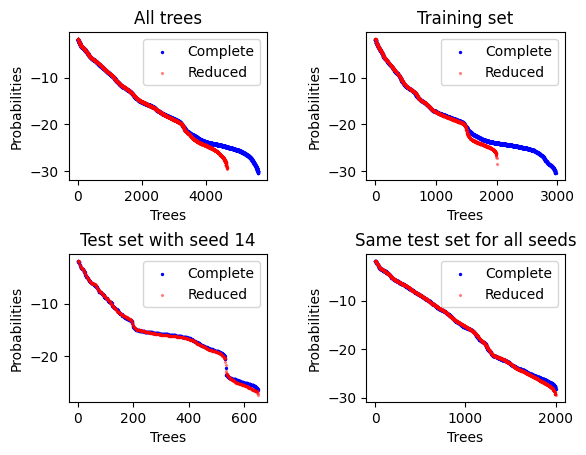

In [189]:
# load the probabilities
prob_14_complete = np.load(os.path.join(results_14_complete, "trees_probabilities_breast_14_complete.npy"))
prob_14_reduced = np.load(os.path.join(results_14_removal, "trees_probabilities_breast_14_reduced.npy"))

# split the probailities based on the set to which the related trees belong
prob_14_complete_train = prob_14_complete[:n_trees_training_14_complete]
prob_14_complete_test_14 = prob_14_complete[n_trees_training_14_complete:n_trees_training_14_complete + n_trees_test_14]
prob_14_complete_test_same = prob_14_complete[n_trees_training_14_complete + n_trees_test_14:]

prob_14_reduced_train = prob_14_reduced[:n_trees_training_14_reduced]
prob_14_reduced_test_14 = prob_14_reduced[n_trees_training_14_reduced:n_trees_training_14_reduced + n_trees_test_14]
prob_14_reduced_test_same = prob_14_reduced[n_trees_training_14_reduced + n_trees_test_14:]

# print some statistics
print("COMPLETE")
print("Max probability: " + str(np.max(prob_14_complete)))
print("Min probability: " + str(np.min(prob_14_complete)))
print("Mean probability: " + str(np.mean(prob_14_complete)))
print("Median probability: " + str(np.median(prob_14_complete)))
print()
print("REDUCED")
print("Max probability: " + str(np.max(prob_14_reduced)))
print("Min probability: " + str(np.min(prob_14_reduced)))
print("Mean probability: " + str(np.mean(prob_14_reduced)))
print("Median probability: " + str(np.median(prob_14_reduced)))
# print("COMPLETE")
# print()
# print("TRAINING SET")
# print("Max probability: " + str(np.max(prob_14_complete_train)))
# print("Min probability: " + str(np.min(prob_14_complete_train)))
# print("Mean probability: " + str(np.mean(prob_14_complete_train)))
# print("Median probability: " + str(np.median(prob_14_complete_train)))
# print()
# print("TEST SET")
# print("Max probability: " + str(np.max(prob_14_complete_test_same)))
# print("Min probability: " + str(np.min(prob_14_complete_test_same)))
# print("Mean probability: " + str(np.mean(prob_14_complete_test_same)))
# print("Median probability: " + str(np.median(prob_14_complete_test_same)))
# print()
# print("REDUCED")
# print()
# print("TRAINING SET")
# print("Max probability: " + str(np.max(prob_14_reduced_train)))
# print("Min probability: " + str(np.min(prob_14_reduced_train)))
# print("Mean probability: " + str(np.mean(prob_14_reduced_train)))
# print("Median probability: " + str(np.median(prob_14_reduced_train)))
# print()
# print("TEST SET")
# print("Max probability: " + str(np.max(prob_14_reduced_test_same)))
# print("Min probability: " + str(np.min(prob_14_reduced_test_same)))
# print("Mean probability: " + str(np.mean(prob_14_reduced_test_same)))
# print("Median probability: " + str(np.median(prob_14_reduced_test_same)))

# sort the probabilities in non-decreasing order
sorted_prob_14_complete = np.sort(prob_14_complete)[::-1]
sorted_prob_14_complete_train = np.sort(prob_14_complete_train)[::-1]
sorted_prob_14_complete_test_14 = np.sort(prob_14_complete_test_14)[::-1]
sorted_prob_14_complete_test_same = np.sort(prob_14_complete_test_same)[::-1]

sorted_prob_14_reduced = np.sort(prob_14_reduced)[::-1]
sorted_prob_14_reduced_train = np.sort(prob_14_reduced_train)[::-1]
sorted_prob_14_reduced_test_14 = np.sort(prob_14_reduced_test_14)[::-1]
sorted_prob_14_reduced_test_same = np.sort(prob_14_reduced_test_same)[::-1]

# plot each corresponding pair of sorted arrays in order to compare performances of the two models
figure, ((axis_all, axis_train), (axis_test_14, axis_test_same)) = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# all trees
axis_all.set_title("All trees")
axis_all.set_xlabel("Trees")
axis_all.set_ylabel("Probabilities")
axis_all.scatter([i for i in range(len(sorted_prob_14_complete))], np.log10(sorted_prob_14_complete), label='Complete', marker='o', color='blue', s=2)
axis_all.scatter([i for i in range(len(sorted_prob_14_reduced))], np.log10(sorted_prob_14_reduced), label='Reduced', marker='x', color='red', s=2, alpha=0.5)
axis_all.legend()

# training set
axis_train.set_title("Training set")
axis_train.set_xlabel("Trees")
axis_train.set_ylabel("Probabilities")
axis_train.scatter([i for i in range(len(sorted_prob_14_complete_train))], np.log10(sorted_prob_14_complete_train), label='Complete', marker='o', color='blue', s=2)
axis_train.scatter([i for i in range(len(sorted_prob_14_reduced_train))], np.log10(sorted_prob_14_reduced_train), label='Reduced', marker='x', color='red', s=2, alpha=0.5)
axis_train.legend()

# test set with seed 14
axis_test_14.set_title("Test set with seed 14")
axis_test_14.set_xlabel("Trees")
axis_test_14.set_ylabel("Probabilities")
axis_test_14.scatter([i for i in range(len(sorted_prob_14_complete_test_14))], np.log10(sorted_prob_14_complete_test_14), label='Complete', marker='o', color='blue', s=2)
axis_test_14.scatter([i for i in range(len(sorted_prob_14_reduced_test_14))], np.log10(sorted_prob_14_reduced_test_14), label='Reduced', marker='x', color='red', s=2, alpha=0.5)
axis_test_14.legend()

# same test set for all seeds
axis_test_same.set_title("Same test set for all seeds")
axis_test_same.set_xlabel("Trees")
axis_test_same.set_ylabel("Probabilities")
axis_test_same.scatter([i for i in range(len(sorted_prob_14_complete_test_same))], np.log10(sorted_prob_14_complete_test_same), label='Complete', marker='o', color='blue', s=2)
axis_test_same.scatter([i for i in range(len(sorted_prob_14_reduced_test_same))], np.log10(sorted_prob_14_reduced_test_same), label='Reduced', marker='x', color='red', s=2, alpha=0.5)
axis_test_same.legend()

plt.show()

# Seed 0

### Random seed

In [190]:
# Set a random seed to allow for reproducibility
RANDOM_SEED = 0

### Paths

In [191]:
# create the folders where to store the training results with this seed
results_0 = os.path.join(results_rem, "seed_0")
if not os.path.exists(results_0):
    os.mkdir(results_0)
    print("Directory" + " seed_0 " + "created successfully.")
else:
    print("Directory" + " seed_0 " + "already exists.")

results_0_complete = os.path.join(results_0, "results_complete")
if not os.path.exists(results_0_complete):
    os.mkdir(results_0_complete)
    print("Directory" + " results_complete " + "created successfully.")
else:
    print("Directory" + " results_complete " + "already exists.")

results_0_removal = os.path.join(results_0, "results_removal")
if not os.path.exists(results_0_removal):
    os.mkdir(results_0_removal)
    print("Directory" + " results_removal " + "created successfully.")
else:
    print("Directory" + " results_removal " + "already exists.")

datasets_0 = os.path.join(results_0, "datasets")
if not os.path.exists(datasets_0):
    os.mkdir(datasets_0)
    print("Directory" + " datasets " + "created successfully.")
else:
    print("Directory" + " datasets " + "already exists.")

Directory seed_0 already exists.
Directory results_complete already exists.
Directory results_removal already exists.
Directory datasets already exists.


### Pre-processing

We do the following steps:
- shuffle treeData using the new random seed;
- split the treeData into a training set with more or less 2000 trees and a test set with the remaining patients;
- add the patient previously removed to the training set;
- save two datasets: the complete one and the reduced version.

In [192]:
# shuffle the dataset
treeData_0_reduced = shuffle_dataset(treeData, os.path.join(datasets_0, "shuffled_dataset.npy"), RANDOM_SEED)

# split the dataset into training set and test set
test_set_0, training_set_0_reduced = split_two_n(treeData_0_reduced, TRAIN_SIZE)

# add the patient previously removed to the training set
training_set_0_complete = [patient for patient in training_set_0_reduced]
training_set_0_complete.append(largest_patient)
training_set_0_complete = np.array(training_set_0_complete, dtype=object)

# print some information regarding the number of patients in each set
print("Total number of patients in the dataset: " + str(len(treeData_0_reduced)))
print("Number of patients in the training set: " + str(len(training_set_0_reduced)))
print("Number of patients in the test set: " + str(len(test_set_0)))
print("Number of patients in the training set (plus removed ones): " + str(len(training_set_0_complete)))
print()


# compute the number of trees in each set
n_trees_0_reduced = 0
for patient in treeData_0_reduced:
    n_trees_0_reduced += len(patient)

n_trees_training_0_reduced = 0
for patient in training_set_0_reduced:
    n_trees_training_0_reduced += len(patient)

n_trees_training_0_complete = 0
for patient in training_set_0_complete:
    n_trees_training_0_complete += len(patient)

n_trees_test_0 = 0
for patient in test_set_0:
    n_trees_test_0 += len(patient)

# print some information regarding the number of trees in each set
print("Total number of trees in the dataset: " + str(n_trees_0_reduced))
print("Number of trees in the training set: " + str(n_trees_training_0_reduced))
print("Number of trees in the test set: " + str(n_trees_test_0))
print("Number of trees in the training set (plus removed ones): " + str(n_trees_training_0_complete))
print()

# save the dataset with the extracted patient
dataset_0_complete = np.concatenate((training_set_0_complete, test_set_0, test_set))
np.save(os.path.join(datasets_0, "dataset_0_complete.npy"), dataset_0_complete)
# save the dataset without the extracted patient
dataset_0_reduced = np.concatenate((training_set_0_reduced, test_set_0, test_set))
np.save(os.path.join(datasets_0, "dataset_0_reduced.npy"), dataset_0_reduced)

# print some information about the datasets
n_dataset_0_complete = 0
for patient in dataset_0_complete:
    n_dataset_0_complete += len(patient)

print("CONSTRUCTED DATASETS")
print("Total number of patients in the dataset with the extracted patient: " + str(len(dataset_0_complete)))
print("Total number of trees in the dataset with the extracted patient: " + str(n_dataset_0_complete))

n_dataset_0_reduced = 0
for patient in dataset_0_reduced:
    n_dataset_0_reduced += len(patient)

print("Total number of patients in the dataset without the extracted patient: " + str(len(dataset_0_reduced)))
print("Total number of trees in the dataset without the extracted patient: " + str(n_dataset_0_reduced))

Total number of patients in the dataset: 593
Number of patients in the training set: 393
Number of patients in the test set: 200
Number of patients in the training set (plus removed ones): 394

Total number of trees in the dataset: 2651
Number of trees in the training set: 2000
Number of trees in the test set: 651
Number of trees in the training set (plus removed ones): 2970

CONSTRUCTED DATASETS
Total number of patients in the dataset with the extracted patient: 1224
Total number of trees in the dataset with the extracted patient: 5621
Total number of patients in the dataset without the extracted patient: 1223
Total number of trees in the dataset without the extracted patient: 4651


### Training with patient

In [193]:
# training a CloMu model on all the patients in the training set, including the one with 970 trees
!python3 CloMu.py train raw ./../results_rem/seed_0/datasets/dataset_0_complete.npy ./../results_rem/seed_0/results_complete/model_complete_0.pt ./../results_rem/seed_0/results_complete/trees_probabilities_breast_0_complete.npy ./../results_rem/seed_0/results_complete/mutationNamesBreastCancer0.npy 9 -trainSize 394 -iter 1000 -verbose

The code runs for 1000 iterations.
The user can stop the code at any time if the testing loss has 
converged sufficiently close to the optimum for the user's applicaiton. 
iteration 0 of 1000

Mean Probability:  1.3556419572730097e-08
Training Score:  -28.343156188432122 Testing Score: -27.91743510338033
Loss:  4.247255280472337
iteration 1 of 1000

Mean Probability:  5.191313218138033e-08
Training Score:  -26.64517993795138 Testing Score: -26.227495258774216
Loss:  3.4844281032211764
iteration 2 of 1000

Mean Probability:  1.2677682214859058e-07
Training Score:  -25.602298483342725 Testing Score: -25.197848566805863
Loss:  2.8216392887793673
iteration 3 of 1000

Mean Probability:  3.405087553680606e-07
Training Score:  -24.682980113404113 Testing Score: -24.290050918359842
Loss:  2.48285384479574
iteration 4 of 1000

Mean Probability:  1.3669449856943421e-06
Training Score:  -23.727359811299934 Testing Score: -23.346319120306827
Loss:  2.2932914900637704
iteration 5 of 1000

Mean Prob

### Training without patient

In [194]:
# training a CloMu model on the patients in the training set, but without the one with 970 trees
!python3 CloMu.py train raw ./../results_rem/seed_0/datasets/dataset_0_reduced.npy ./../results_rem/seed_0/results_removal/model_reduced_0.pt ./../results_rem/seed_0/results_removal/trees_probabilities_breast_0_reduced.npy ./../results_rem/seed_0/results_removal/mutationNamesBreastCancer0.npy 9 -trainSize 393 -iter 1000 -verbose

The code runs for 1000 iterations.
The user can stop the code at any time if the testing loss has 
converged sufficiently close to the optimum for the user's applicaiton. 
iteration 0 of 1000

Mean Probability:  1.5817205921459973e-08
Training Score:  -28.316665451843168 Testing Score: -27.921199906383052
Loss:  6.214792178214968
iteration 1 of 1000

Mean Probability:  7.711781646095009e-08
Training Score:  -26.249256562958273 Testing Score: -25.894230919963725
Loss:  5.139320572749766
iteration 2 of 1000

Mean Probability:  3.065931955838751e-07
Training Score:  -24.86830058482148 Testing Score: -24.575839254514108
Loss:  4.253715769966002
iteration 3 of 1000

Mean Probability:  2.3198366542957894e-06
Training Score:  -23.67199198185663 Testing Score: -23.436893237914077
Loss:  3.604928445407053
iteration 4 of 1000

Mean Probability:  1.5530504007155874e-05
Training Score:  -22.82635826703279 Testing Score: -22.622051405787623
Loss:  2.8150263539517164
iteration 5 of 1000

Mean Probab

### Comparison

COMPLETE
Max probability: 0.016493447200952565
Min probability: 5.7070586230915205e-30
Mean probability: 0.0001008532845752063
Median probability: 5.054646839209046e-19

REDUCED
Max probability: 0.015190055425479191
Min probability: 4.506573972649404e-30
Mean probability: 0.00013239036976874486
Median probability: 7.977883674335227e-17


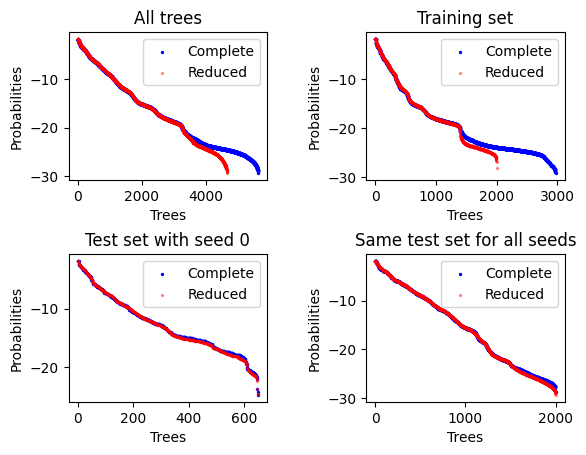

In [195]:
# load the probabilities
prob_0_complete = np.load(os.path.join(results_0_complete, "trees_probabilities_breast_0_complete.npy"))
prob_0_reduced = np.load(os.path.join(results_0_removal, "trees_probabilities_breast_0_reduced.npy"))

# split the probailities based on the set to which the related trees belong
prob_0_complete_train = prob_0_complete[:n_trees_training_0_complete]
prob_0_complete_test_0 = prob_0_complete[n_trees_training_0_complete:n_trees_training_0_complete + n_trees_test_0]
prob_0_complete_test_same = prob_0_complete[n_trees_training_0_complete + n_trees_test_0:]

prob_0_reduced_train = prob_0_reduced[:n_trees_training_0_reduced]
prob_0_reduced_test_0 = prob_0_reduced[n_trees_training_0_reduced:n_trees_training_0_reduced + n_trees_test_0]
prob_0_reduced_test_same = prob_0_reduced[n_trees_training_0_reduced + n_trees_test_0:]

# print some statistics
print("COMPLETE")
print("Max probability: " + str(np.max(prob_0_complete)))
print("Min probability: " + str(np.min(prob_0_complete)))
print("Mean probability: " + str(np.mean(prob_0_complete)))
print("Median probability: " + str(np.median(prob_0_complete)))
print()
print("REDUCED")
print("Max probability: " + str(np.max(prob_0_reduced)))
print("Min probability: " + str(np.min(prob_0_reduced)))
print("Mean probability: " + str(np.mean(prob_0_reduced)))
print("Median probability: " + str(np.median(prob_0_reduced)))
# print("COMPLETE")
# print()
# print("TRAINING SET")
# print("Max probability: " + str(np.max(prob_0_complete_train)))
# print("Min probability: " + str(np.min(prob_0_complete_train)))
# print("Mean probability: " + str(np.mean(prob_0_complete_train)))
# print("Median probability: " + str(np.median(prob_0_complete_train)))
# print()
# print("TEST SET")
# print("Max probability: " + str(np.max(prob_0_complete_test_same)))
# print("Min probability: " + str(np.min(prob_0_complete_test_same)))
# print("Mean probability: " + str(np.mean(prob_0_complete_test_same)))
# print("Median probability: " + str(np.median(prob_0_complete_test_same)))
# print()
# print("REDUCED")
# print()
# print("TRAINING SET")
# print("Max probability: " + str(np.max(prob_0_reduced_train)))
# print("Min probability: " + str(np.min(prob_0_reduced_train)))
# print("Mean probability: " + str(np.mean(prob_0_reduced_train)))
# print("Median probability: " + str(np.median(prob_0_reduced_train)))
# print()
# print("TEST SET")
# print("Max probability: " + str(np.max(prob_0_reduced_test_same)))
# print("Min probability: " + str(np.min(prob_0_reduced_test_same)))
# print("Mean probability: " + str(np.mean(prob_0_reduced_test_same)))
# print("Median probability: " + str(np.median(prob_0_reduced_test_same)))

# sort the probabilities in non-decreasing order
sorted_prob_0_complete = np.sort(prob_0_complete)[::-1]
sorted_prob_0_complete_train = np.sort(prob_0_complete_train)[::-1]
sorted_prob_0_complete_test_0 = np.sort(prob_0_complete_test_0)[::-1]
sorted_prob_0_complete_test_same = np.sort(prob_0_complete_test_same)[::-1]

sorted_prob_0_reduced = np.sort(prob_0_reduced)[::-1]
sorted_prob_0_reduced_train = np.sort(prob_0_reduced_train)[::-1]
sorted_prob_0_reduced_test_0 = np.sort(prob_0_reduced_test_0)[::-1]
sorted_prob_0_reduced_test_same = np.sort(prob_0_reduced_test_same)[::-1]

# plot each corresponding pair of sorted arrays in order to compare performances of the two models
figure, ((axis_all, axis_train), (axis_test_0, axis_test_same)) = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# all trees
axis_all.set_title("All trees")
axis_all.set_xlabel("Trees")
axis_all.set_ylabel("Probabilities")
axis_all.scatter([i for i in range(len(sorted_prob_0_complete))], np.log10(sorted_prob_0_complete), label='Complete', marker='o', color='blue', s=2)
axis_all.scatter([i for i in range(len(sorted_prob_0_reduced))], np.log10(sorted_prob_0_reduced), label='Reduced', marker='x', color='red', s=2, alpha=0.5)
axis_all.legend()

# training set
axis_train.set_title("Training set")
axis_train.set_xlabel("Trees")
axis_train.set_ylabel("Probabilities")
axis_train.scatter([i for i in range(len(sorted_prob_0_complete_train))], np.log10(sorted_prob_0_complete_train), label='Complete', marker='o', color='blue', s=2)
axis_train.scatter([i for i in range(len(sorted_prob_0_reduced_train))], np.log10(sorted_prob_0_reduced_train), label='Reduced', marker='x', color='red', s=2, alpha=0.5)
axis_train.legend()

# test set with seed 0
axis_test_0.set_title("Test set with seed 0")
axis_test_0.set_xlabel("Trees")
axis_test_0.set_ylabel("Probabilities")
axis_test_0.scatter([i for i in range(len(sorted_prob_0_complete_test_0))], np.log10(sorted_prob_0_complete_test_0), label='Complete', marker='o', color='blue', s=2)
axis_test_0.scatter([i for i in range(len(sorted_prob_0_reduced_test_0))], np.log10(sorted_prob_0_reduced_test_0), label='Reduced', marker='x', color='red', s=2, alpha=0.5)
axis_test_0.legend()

# same test set for all seeds
axis_test_same.set_title("Same test set for all seeds")
axis_test_same.set_xlabel("Trees")
axis_test_same.set_ylabel("Probabilities")
axis_test_same.scatter([i for i in range(len(sorted_prob_0_complete_test_same))], np.log10(sorted_prob_0_complete_test_same), label='Complete', marker='o', color='blue', s=2)
axis_test_same.scatter([i for i in range(len(sorted_prob_0_reduced_test_same))], np.log10(sorted_prob_0_reduced_test_same), label='Reduced', marker='x', color='red', s=2, alpha=0.5)
axis_test_same.legend()

plt.show()

# Final comparison

## Plots

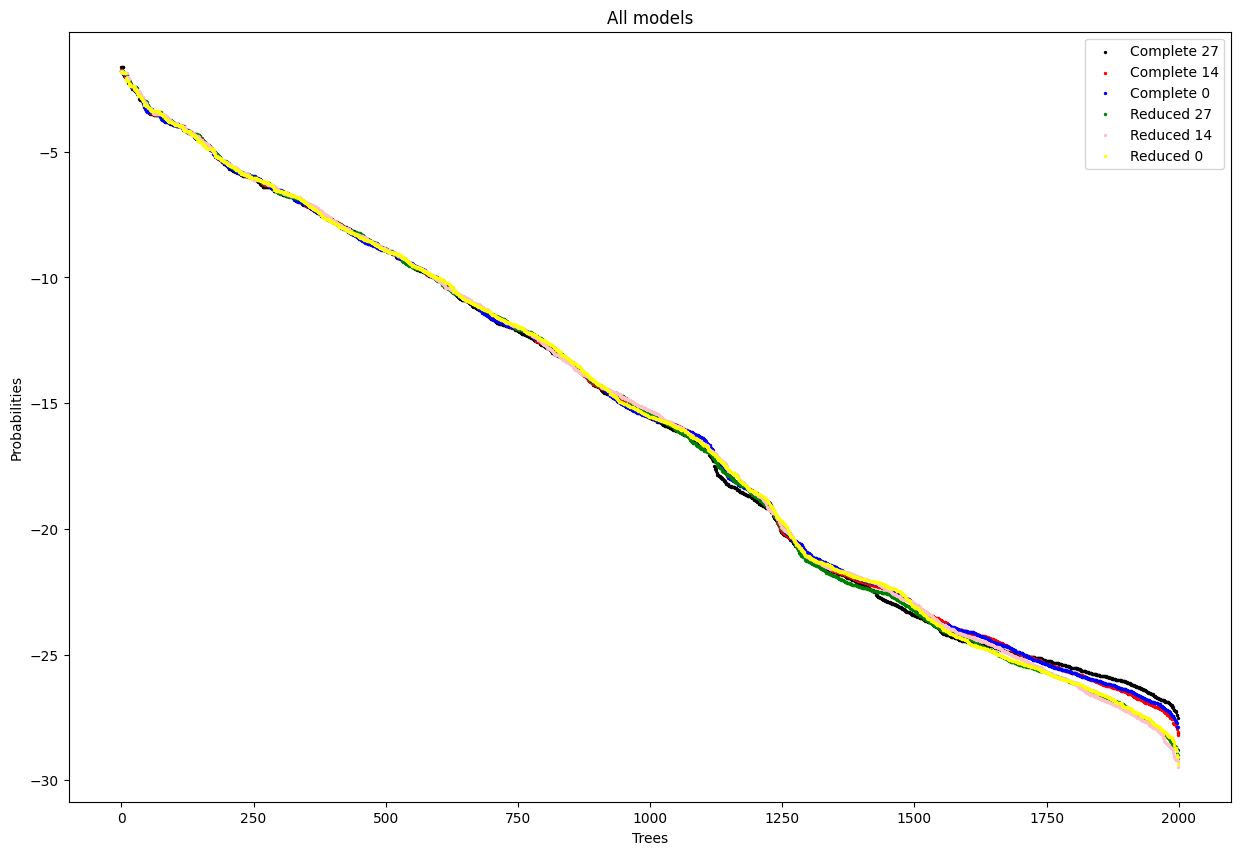

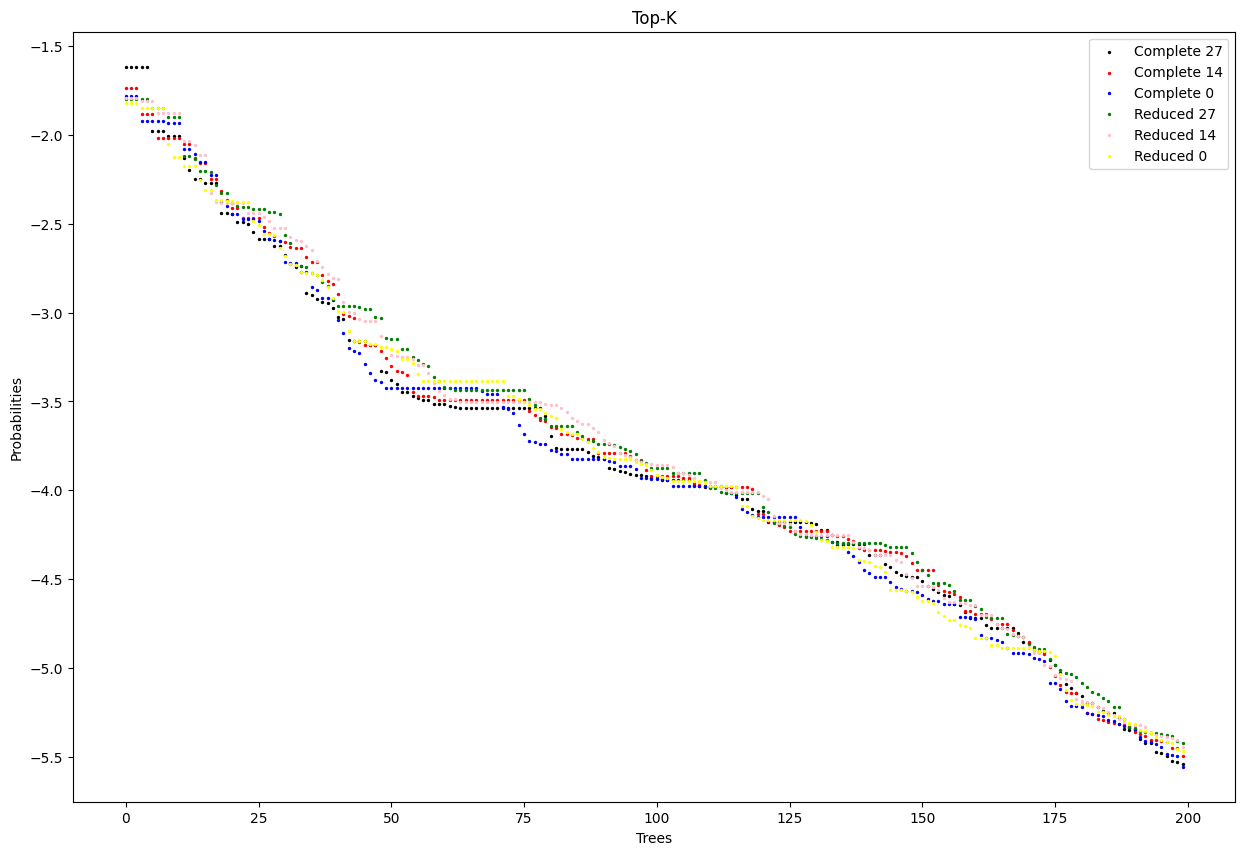

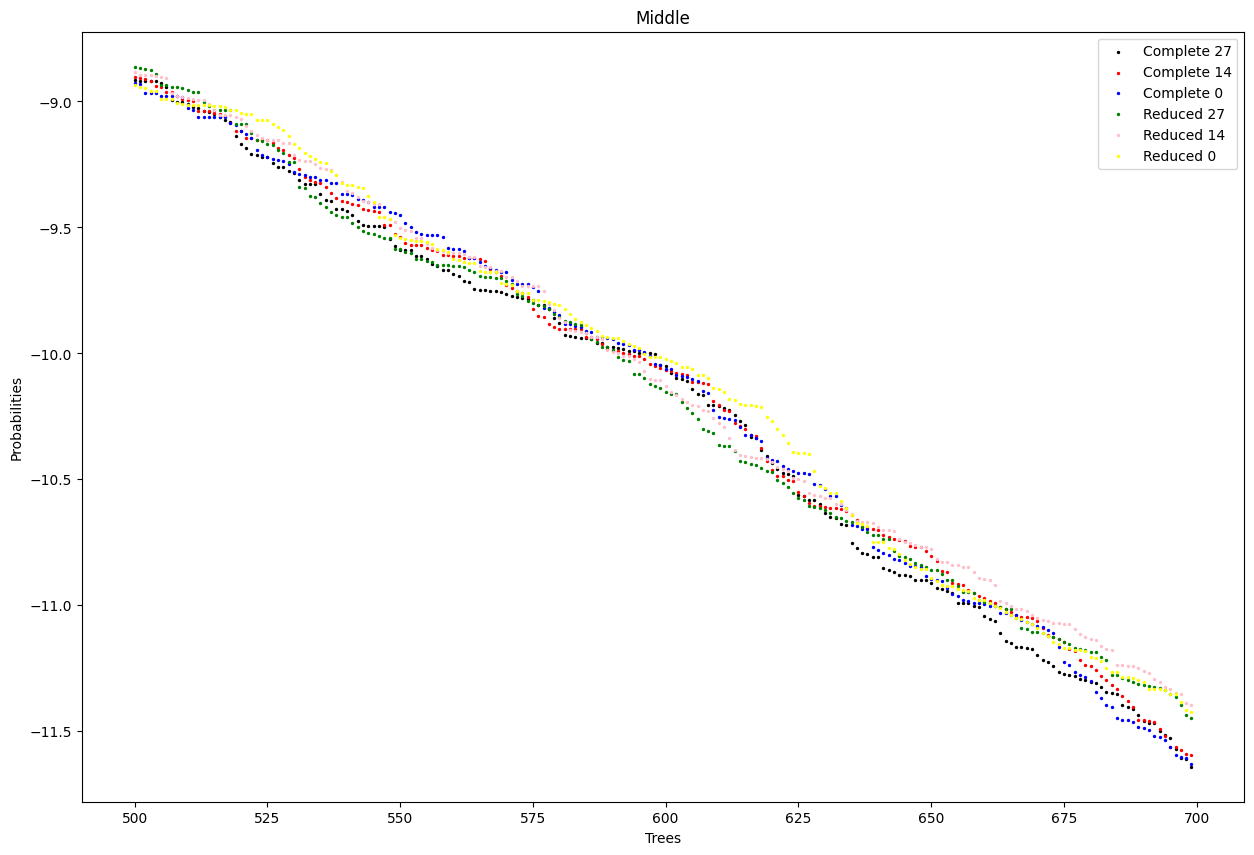

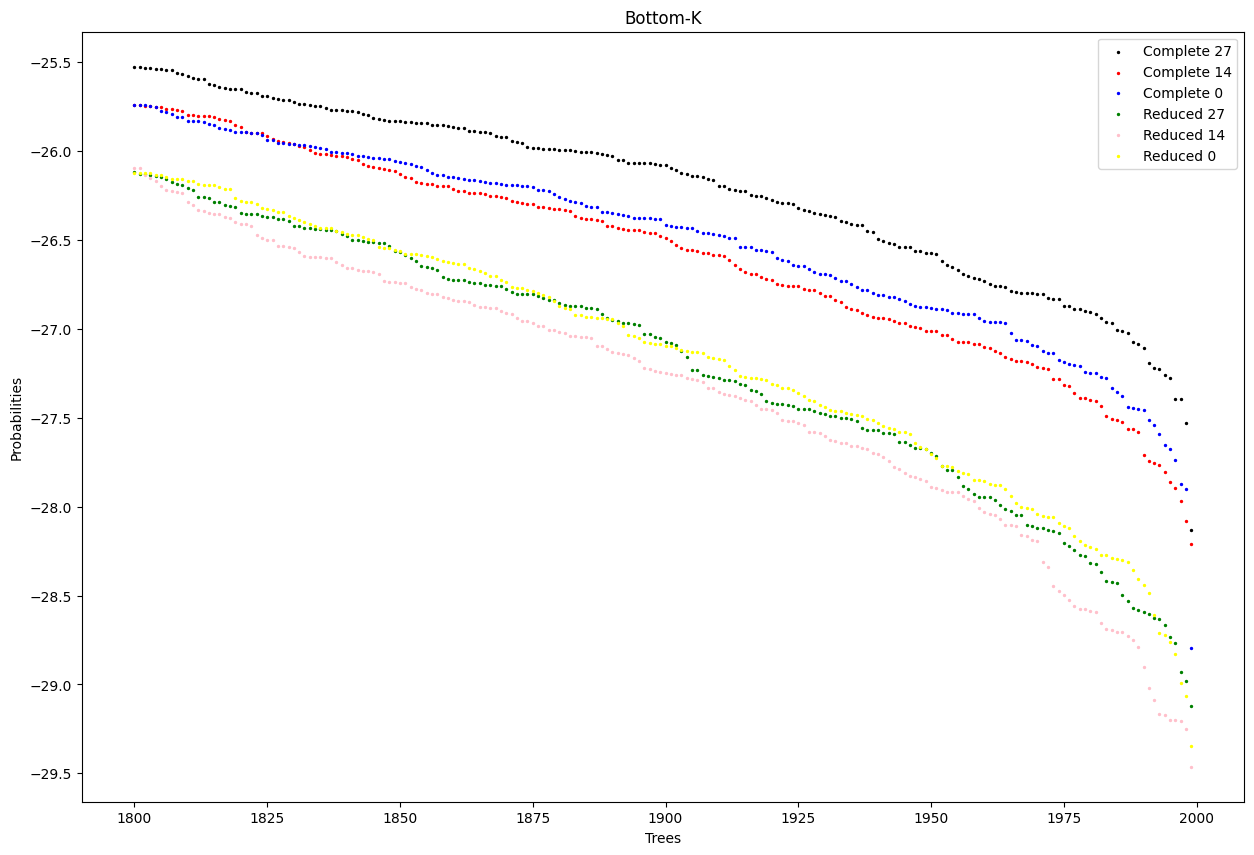

In [211]:
# all the plots consider trees belonging to the same test set
x = [i for i in range(n_trees_test)]

# plot all probabilities from all models on the same test set
figure, ax = plt.subplots(figsize=(15, 10))

ax.set_title("All models")
ax.set_xlabel("Trees")
ax.set_ylabel("Probabilities")

ax.scatter(x, np.log10(sorted_prob_27_complete_test_same), label='Complete 27', marker='o', color='black', s=2)
ax.scatter(x, np.log10(sorted_prob_14_complete_test_same), label='Complete 14', marker='o', color='red', s=2)
ax.scatter(x, np.log10(sorted_prob_0_complete_test_same), label='Complete 0', marker='o', color='blue', s=2)

ax.scatter(x, np.log10(sorted_prob_27_reduced_test_same), label='Reduced 27', marker='o', color='green', s=2)
ax.scatter(x, np.log10(sorted_prob_14_reduced_test_same), label='Reduced 14', marker='o', color='pink', s=2)
ax.scatter(x, np.log10(sorted_prob_0_reduced_test_same), label='Reduced 0', marker='o', color='yellow', s=2)

ax.legend()
plt.show()

# plot only the top-K probabilities from all models
figure, ax = plt.subplots(figsize=(15, 10))
K = 200

ax.set_title("Top-K")
ax.set_xlabel("Trees")
ax.set_ylabel("Probabilities")

ax.scatter(x[:K], np.log10(sorted_prob_27_complete_test_same[:K]), label='Complete 27', marker='o', color='black', s=2)
ax.scatter(x[:K], np.log10(sorted_prob_14_complete_test_same[:K]), label='Complete 14', marker='o', color='red', s=2)
ax.scatter(x[:K], np.log10(sorted_prob_0_complete_test_same[:K]), label='Complete 0', marker='o', color='blue', s=2)

ax.scatter(x[:K], np.log10(sorted_prob_27_reduced_test_same[:K]), label='Reduced 27', marker='o', color='green', s=2)
ax.scatter(x[:K], np.log10(sorted_prob_14_reduced_test_same[:K]), label='Reduced 14', marker='o', color='pink', s=2)
ax.scatter(x[:K], np.log10(sorted_prob_0_reduced_test_same[:K]), label='Reduced 0', marker='o', color='yellow', s=2)

ax.legend()
plt.show()

# plot only the K probabilities in the middle from all models
figure, ax = plt.subplots(figsize=(15, 10))
start = 500
end = start + K

ax.set_title("Middle")
ax.set_xlabel("Trees")
ax.set_ylabel("Probabilities")

ax.scatter(x[start:end], np.log10(sorted_prob_27_complete_test_same[start:end]), label='Complete 27', marker='o', color='black', s=2)
ax.scatter(x[start:end], np.log10(sorted_prob_14_complete_test_same[start:end]), label='Complete 14', marker='o', color='red', s=2)
ax.scatter(x[start:end], np.log10(sorted_prob_0_complete_test_same[start:end]), label='Complete 0', marker='o', color='blue', s=2)

ax.scatter(x[start:end], np.log10(sorted_prob_27_reduced_test_same[start:end]), label='Reduced 27', marker='o', color='green', s=2)
ax.scatter(x[start:end], np.log10(sorted_prob_14_reduced_test_same[start:end]), label='Reduced 14', marker='o', color='pink', s=2)
ax.scatter(x[start:end], np.log10(sorted_prob_0_reduced_test_same[start:end]), label='Reduced 0', marker='o', color='yellow', s=2)

ax.legend()
plt.show()

# plot only the bottom-K probabilities from all models
figure, ax = plt.subplots(figsize=(15, 10))
K = 200

ax.set_title("Bottom-K")
ax.set_xlabel("Trees")
ax.set_ylabel("Probabilities")

ax.scatter(x[-K:], np.log10(sorted_prob_27_complete_test_same[-K:]), label='Complete 27', marker='o', color='black', s=2)
ax.scatter(x[-K:], np.log10(sorted_prob_14_complete_test_same[-K:]), label='Complete 14', marker='o', color='red', s=2)
ax.scatter(x[-K:], np.log10(sorted_prob_0_complete_test_same[-K:]), label='Complete 0', marker='o', color='blue', s=2)

ax.scatter(x[-K:], np.log10(sorted_prob_27_reduced_test_same[-K:]), label='Reduced 27', marker='o', color='green', s=2)
ax.scatter(x[-K:], np.log10(sorted_prob_14_reduced_test_same[-K:]), label='Reduced 14', marker='o', color='pink', s=2)
ax.scatter(x[-K:], np.log10(sorted_prob_0_reduced_test_same[-K:]), label='Reduced 0', marker='o', color='yellow', s=2)

ax.legend()
plt.show()

## Distance measures

Mean probability assigned to test trees by the three complete models: 0.00014139517565587274
Mean probability assigned to test trees by the three reduced models: 0.00014649632813379916


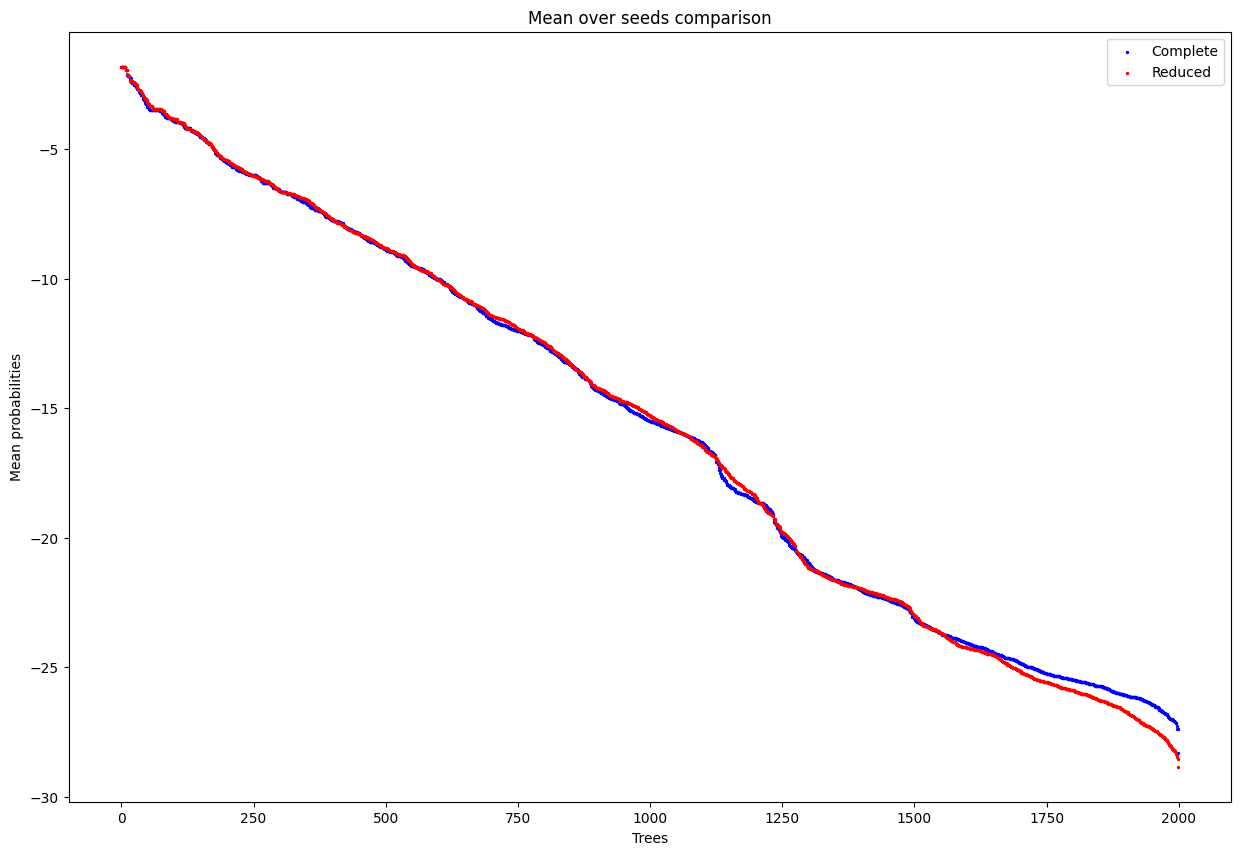

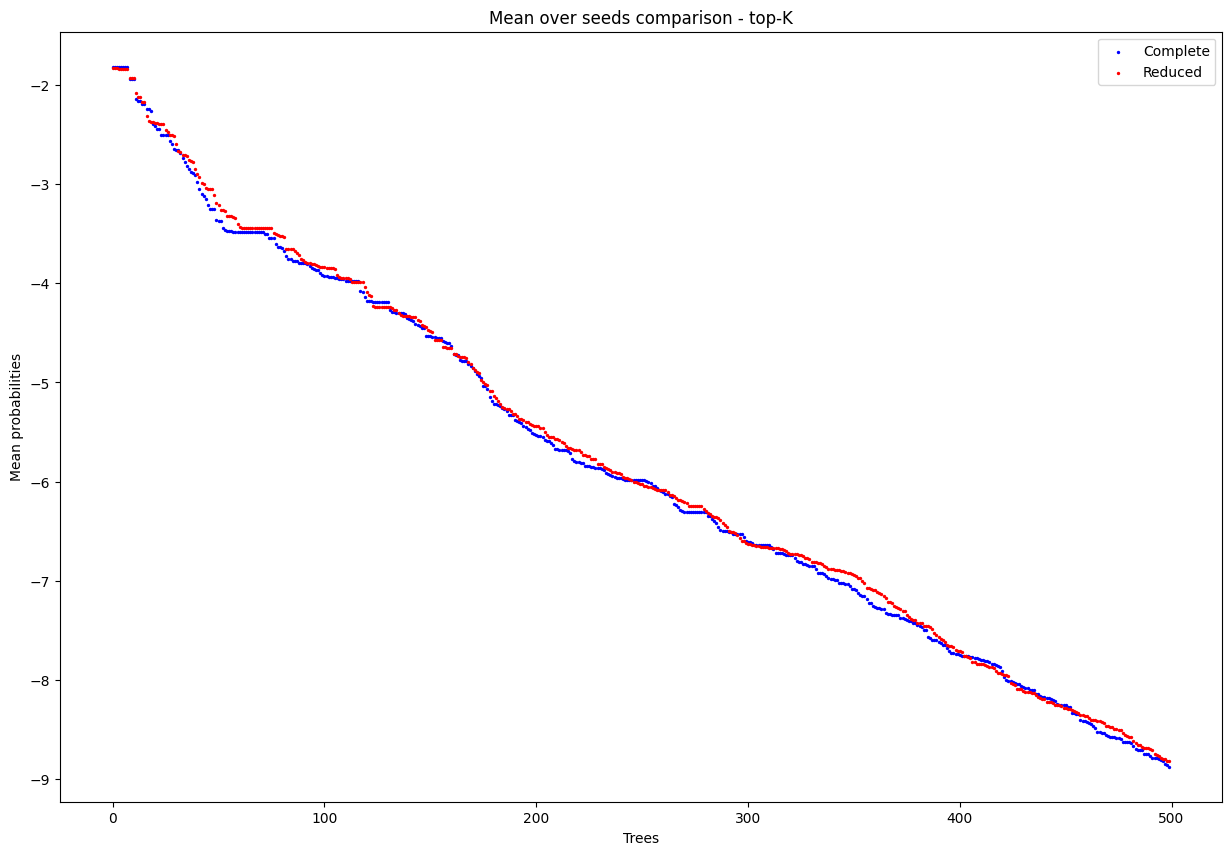

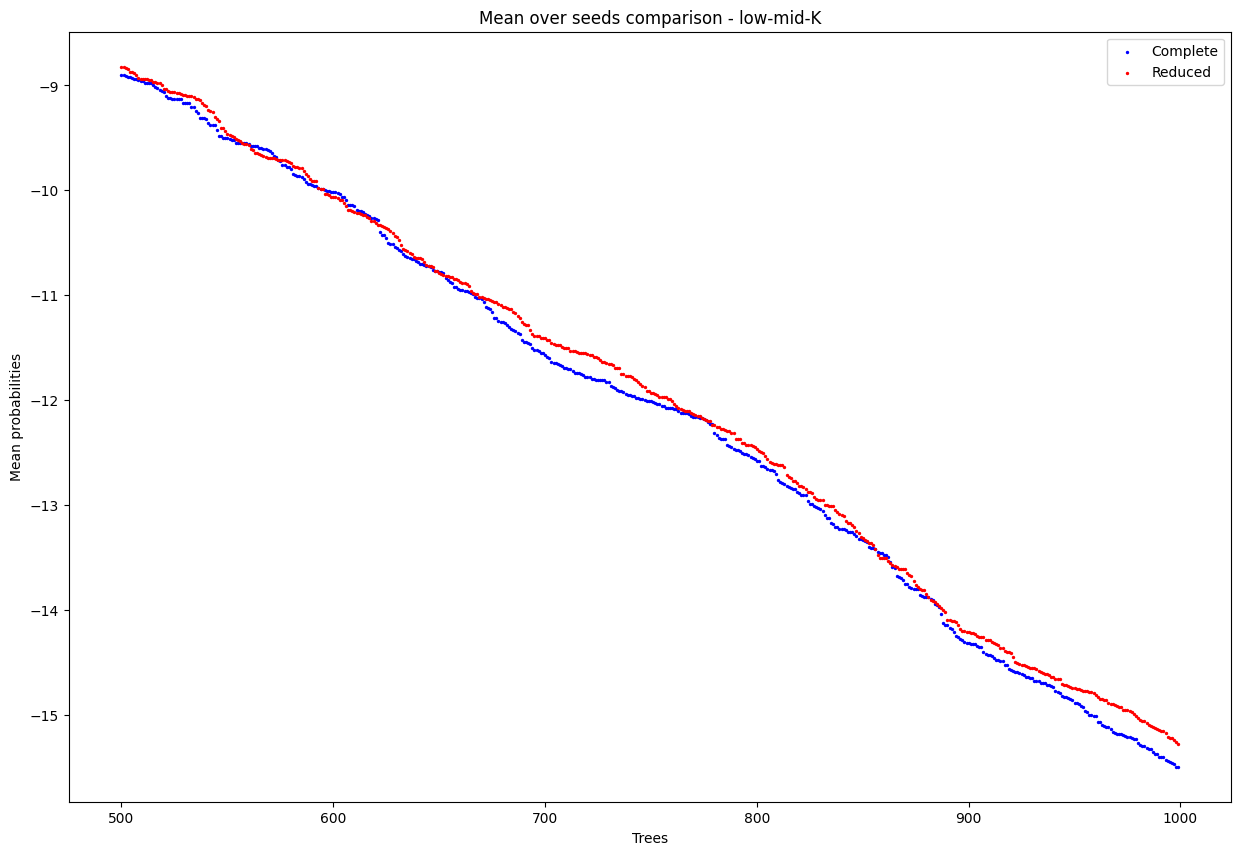

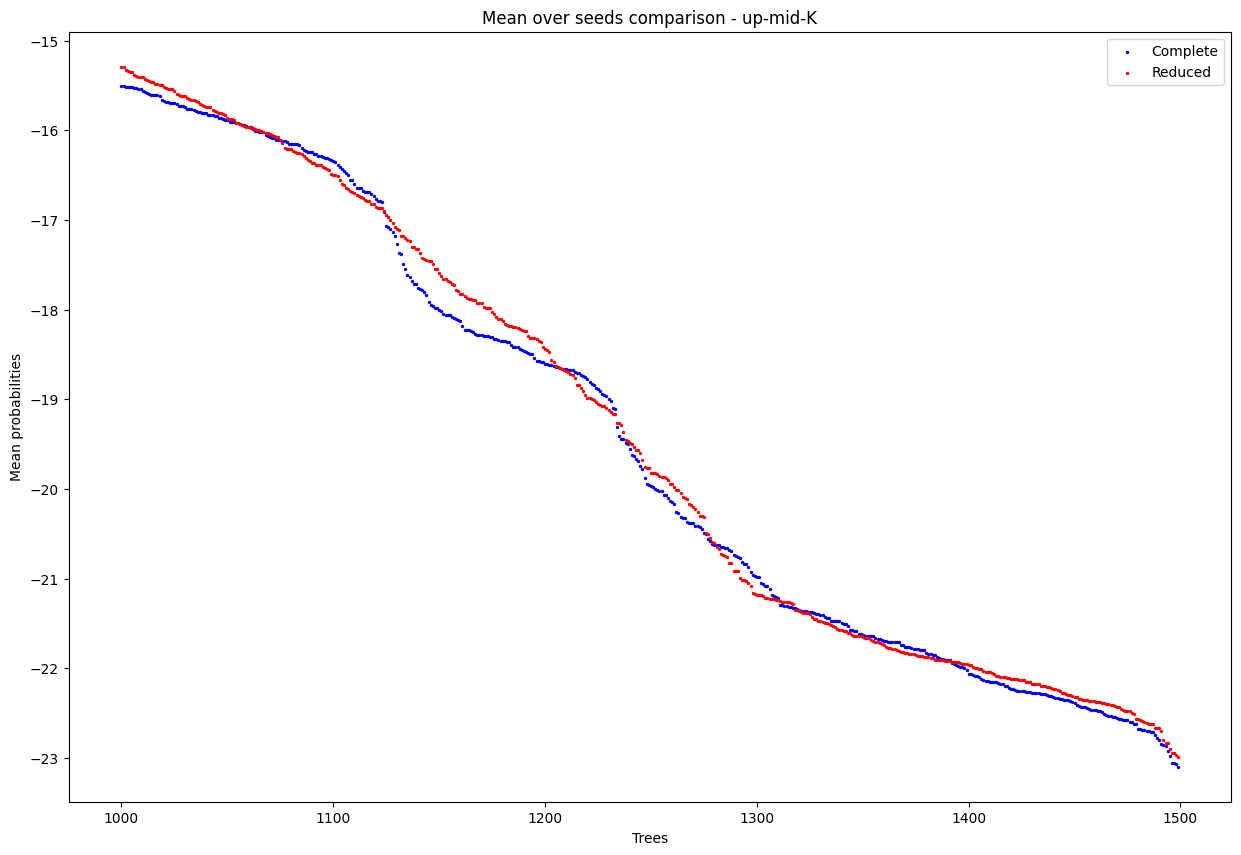

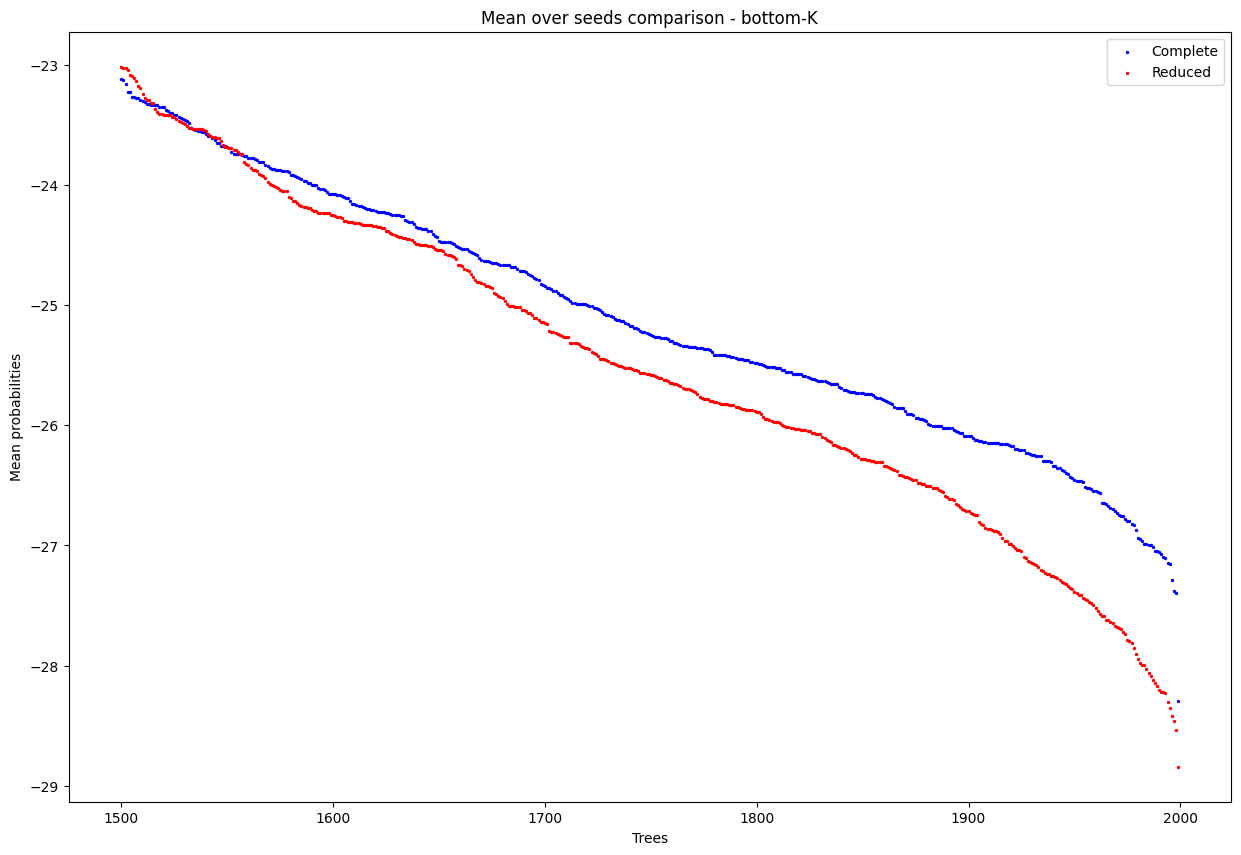

Mean distance from reduced model with seed 27 to the mean of the complete models: 2.477417926883538e-05
Mean distance from reduced model with seed 27 to the mean of the reduced models: 2.3529322167255263e-05


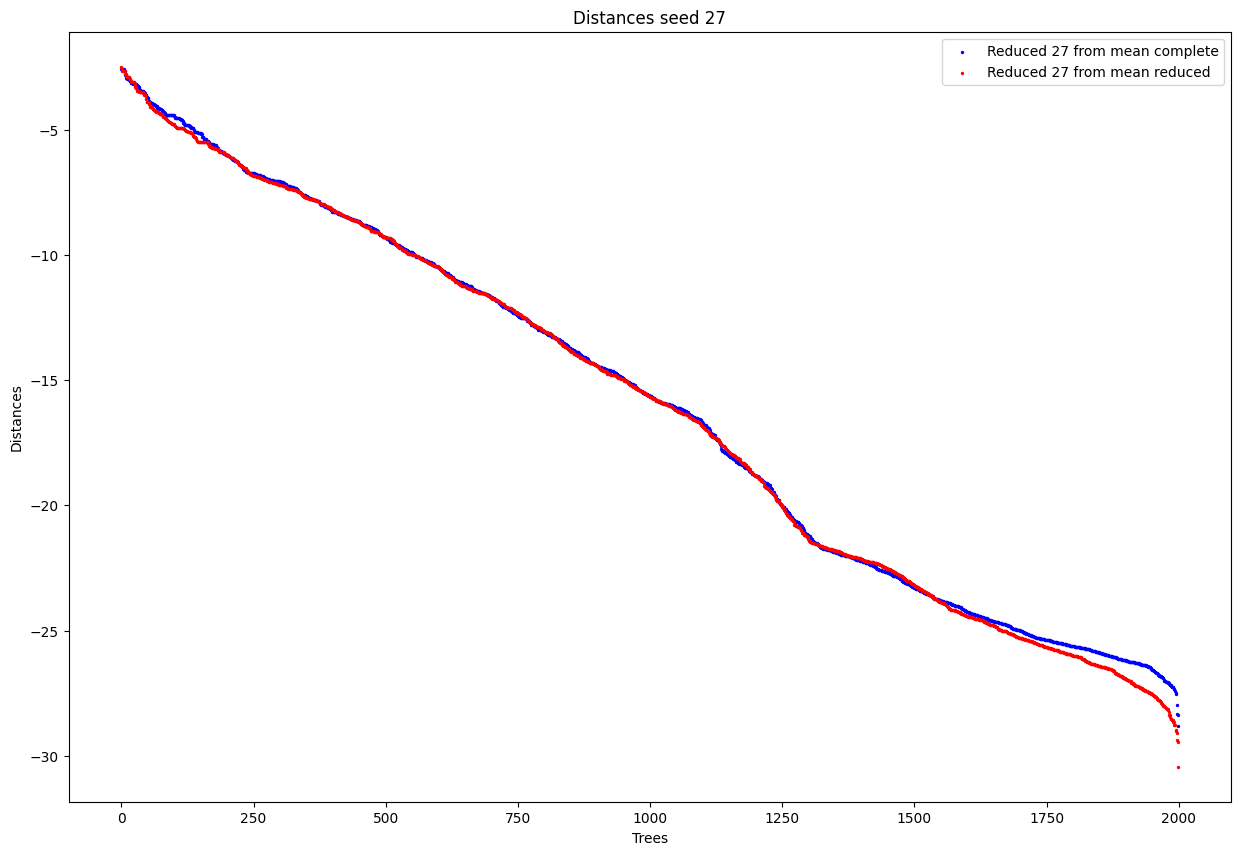

Mean distance from reduced model with seed 14 to the mean of the complete models: 3.126875145036699e-05
Mean distance from reduced model with seed 14 to the mean of the reduced models: 2.8909211671916594e-05


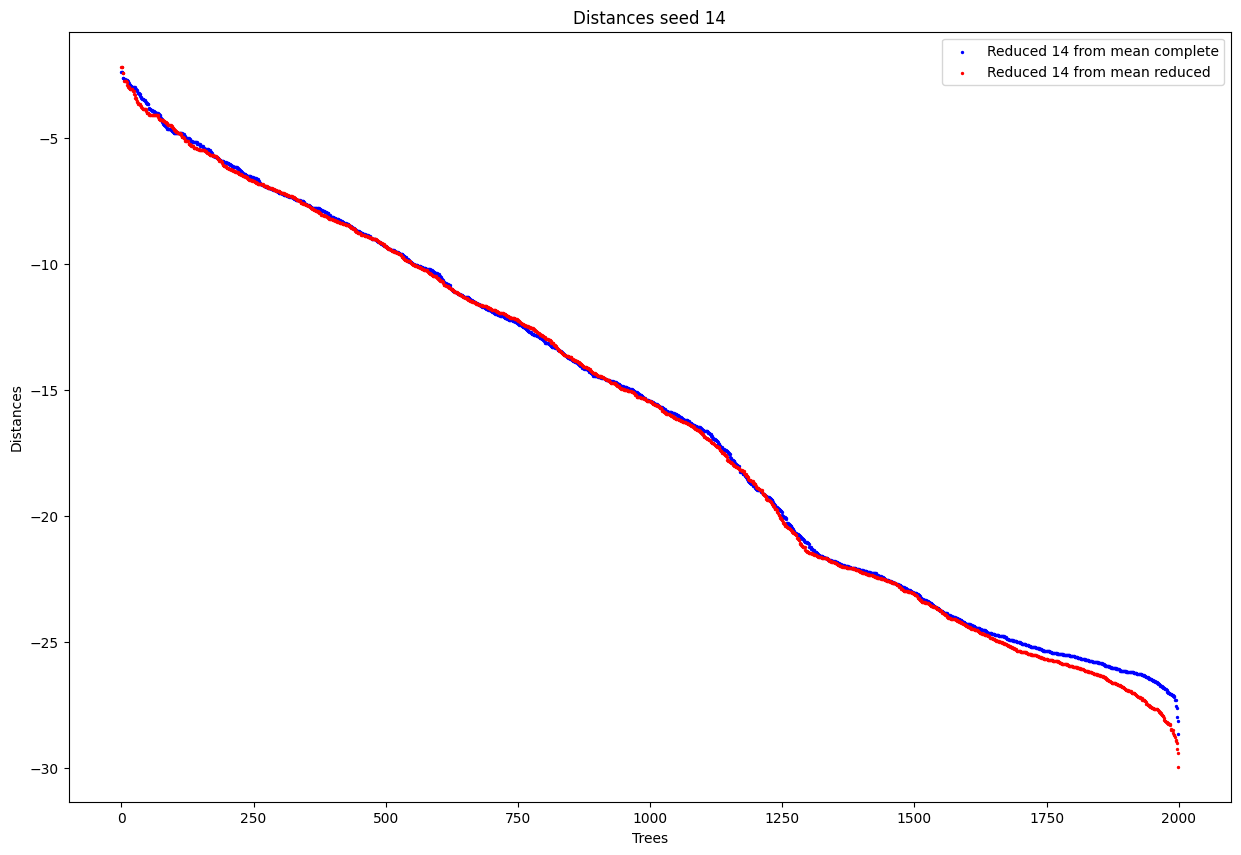

Mean distance from reduced model with seed 0 to the mean of the complete models: 3.814275600586102e-05
Mean distance from reduced model with seed 0 to the mean of the reduced models: 2.8663157520667198e-05


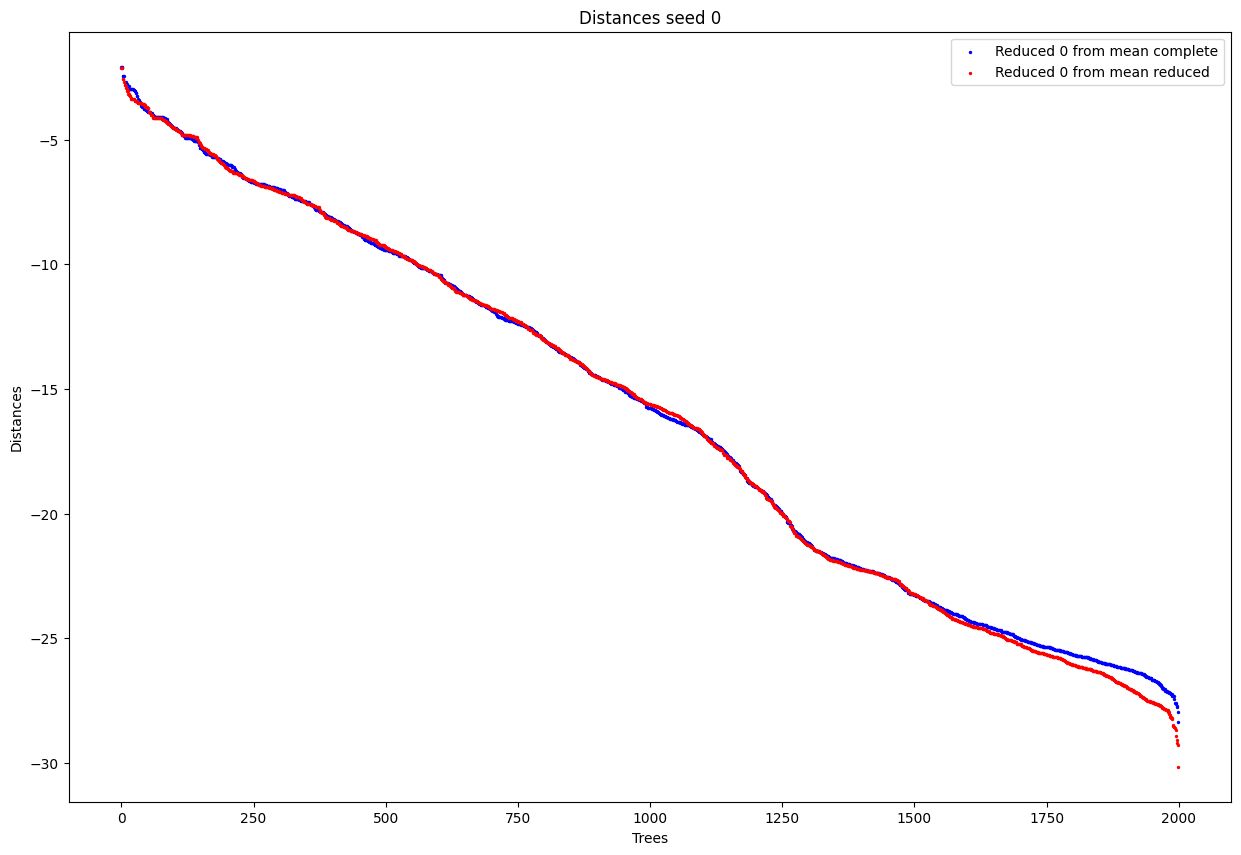

In [233]:
# for each tree, we assign it the mean of the three probabilities from the three complete models
mean_complete = []
for i in range(n_trees_test):
    mean_complete.append(np.mean([prob_27_complete_test_same[i], prob_14_complete_test_same[i], prob_0_complete_test_same[i]]))

# for each tree, we assign it the mean of the three probabilities from the three reduced models
mean_reduced = []
for i in range(n_trees_test):
    mean_reduced.append(np.mean([prob_27_reduced_test_same[i], prob_14_reduced_test_same[i], prob_0_reduced_test_same[i]]))

# print the two computed quantities
print("Mean probability assigned to test trees by the three complete models: " + str(np.mean(mean_complete)))
print("Mean probability assigned to test trees by the three reduced models: " + str(np.mean(mean_reduced)))

# plot the mean probabilities
figure, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Mean over seeds comparison")
ax.set_xlabel("Trees")
ax.set_ylabel("Mean probabilities")

ax.scatter(x, np.log10(np.sort(mean_complete)[::-1]), label='Complete', marker='o', color='blue', s=2)
ax.scatter(x, np.log10(np.sort(mean_reduced)[::-1]), label='Reduced', marker='o', color='red', s=2)

ax.legend()
plt.show()

# plot the top-K mean probabilities
figure, ax = plt.subplots(figsize=(15, 10))

K = 500

ax.set_title("Mean over seeds comparison - top-K")
ax.set_xlabel("Trees")
ax.set_ylabel("Mean probabilities")

ax.scatter(x[:K], np.log10(np.sort(mean_complete)[::-1][:K]), label='Complete', marker='o', color='blue', s=2)
ax.scatter(x[:K], np.log10(np.sort(mean_reduced)[::-1][:K]), label='Reduced', marker='o', color='red', s=2)

ax.legend()
plt.show()

# plot the low-mid-K mean probabilities
figure, ax = plt.subplots(figsize=(15, 10))

start = K
end = start + K

ax.set_title("Mean over seeds comparison - low-mid-K")
ax.set_xlabel("Trees")
ax.set_ylabel("Mean probabilities")

ax.scatter(x[start:end], np.log10(np.sort(mean_complete)[::-1][start:end]), label='Complete', marker='o', color='blue', s=2)
ax.scatter(x[start:end], np.log10(np.sort(mean_reduced)[::-1][start:end]), label='Reduced', marker='o', color='red', s=2)

ax.legend()
plt.show()

# plot the up-mid-K mean probabilities
figure, ax = plt.subplots(figsize=(15, 10))

start = end
end = start + K

ax.set_title("Mean over seeds comparison - up-mid-K")
ax.set_xlabel("Trees")
ax.set_ylabel("Mean probabilities")

ax.scatter(x[start:end], np.log10(np.sort(mean_complete)[::-1][start:end]), label='Complete', marker='o', color='blue', s=2)
ax.scatter(x[start:end], np.log10(np.sort(mean_reduced)[::-1][start:end]), label='Reduced', marker='o', color='red', s=2)

ax.legend()
plt.show()

# plot the bottom-K mean probabilities
figure, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Mean over seeds comparison - bottom-K")
ax.set_xlabel("Trees")
ax.set_ylabel("Mean probabilities")

ax.scatter(x[-K:], np.log10(np.sort(mean_complete)[::-1][-K:]), label='Complete', marker='o', color='blue', s=2)
ax.scatter(x[-K:], np.log10(np.sort(mean_reduced)[::-1][-K:]), label='Reduced', marker='o', color='red', s=2)

ax.legend()
plt.show()

# SEED 27

# for each tree, we compute the distance from the probability assigned to it by the reduced model with random seed 27
# to the mean probability assigned by the complete models
dist_reduced_27_to_complete = []
for i in range(n_trees_test):
    dist_reduced_27_to_complete.append(np.abs(prob_27_reduced_test_same[i] - mean_complete[i]))

# for each tree, we compute the distance from the probability assigned to it by the reduced model with random seed 27
# to the mean probability assigned by the other two reduced models
dist_reduced_27_to_reduced = []
for i in range(n_trees_test):
    mean_red = np.mean([prob_14_reduced_test_same[i], prob_0_reduced_test_same[i]])
    dist_reduced_27_to_reduced.append(np.abs(prob_27_reduced_test_same[i] - mean_red))

# print some statistics
print("Mean distance from reduced model with seed 27 to the mean of the complete models: " + str(np.mean(dist_reduced_27_to_complete)))
print("Mean distance from reduced model with seed 27 to the mean of the reduced models: " + str(np.mean(dist_reduced_27_to_reduced)))

# plot the two created lists
figure, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Distances seed 27")
ax.set_xlabel("Trees")
ax.set_ylabel("Distances")

ax.scatter(x, np.log10(np.sort(dist_reduced_27_to_complete)[::-1]), label='Reduced 27 from mean complete', marker='o', color='blue', s=2)
ax.scatter(x, np.log10(np.sort(dist_reduced_27_to_reduced)[::-1]), label='Reduced 27 from mean reduced', marker='o', color='red', s=2)

ax.legend()
plt.show()

# SEED 14

# for each tree, we compute the distance from the probability assigned to it by the reduced model with random seed 14
# to the mean probability assigned by the complete models
dist_reduced_14_to_complete = []
for i in range(n_trees_test):
    dist_reduced_14_to_complete.append(np.abs(prob_14_reduced_test_same[i] - mean_complete[i]))

# for each tree, we compute the distance from the probability assigned to it by the reduced model with random seed 14
# to the mean probability assigned by all the reduced models
dist_reduced_14_to_reduced = []
for i in range(n_trees_test):
    mean_red = np.mean([prob_27_reduced_test_same[i], prob_0_reduced_test_same[i]])
    dist_reduced_14_to_reduced.append(np.abs(prob_14_reduced_test_same[i] - mean_red))

# print some statistics
print("Mean distance from reduced model with seed 14 to the mean of the complete models: " + str(np.mean(dist_reduced_14_to_complete)))
print("Mean distance from reduced model with seed 14 to the mean of the reduced models: " + str(np.mean(dist_reduced_14_to_reduced)))


# plot the two created lists
figure, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Distances seed 14")
ax.set_xlabel("Trees")
ax.set_ylabel("Distances")

ax.scatter(x, np.log10(np.sort(dist_reduced_14_to_complete)[::-1]), label='Reduced 14 from mean complete', marker='o', color='blue', s=2)
ax.scatter(x, np.log10(np.sort(dist_reduced_14_to_reduced)[::-1]), label='Reduced 14 from mean reduced', marker='o', color='red', s=2)

ax.legend()
plt.show()

# SEED 0

# for each tree, we compute the distance from the probability assigned to it by the reduced model with random seed 0
# to the mean probability assigned by the complete models
dist_reduced_0_to_complete = []
for i in range(n_trees_test):
    dist_reduced_0_to_complete.append(np.abs(prob_0_reduced_test_same[i] - mean_complete[i]))

# for each tree, we compute the distance from the probability assigned to it by the reduced model with random seed 0
# to the mean probability assigned by all the reduced models
dist_reduced_0_to_reduced = []
for i in range(n_trees_test):
    mean_red = np.mean([prob_27_reduced_test_same[i], prob_14_reduced_test_same[i]])
    dist_reduced_0_to_reduced.append(np.abs(prob_0_reduced_test_same[i] - mean_red))

# print some statistics
print("Mean distance from reduced model with seed 0 to the mean of the complete models: " + str(np.mean(dist_reduced_0_to_complete)))
print("Mean distance from reduced model with seed 0 to the mean of the reduced models: " + str(np.mean(dist_reduced_0_to_reduced)))


# plot the two created lists
figure, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Distances seed 0")
ax.set_xlabel("Trees")
ax.set_ylabel("Distances")

ax.scatter(x, np.log10(np.sort(dist_reduced_0_to_complete)[::-1]), label='Reduced 0 from mean complete', marker='o', color='blue', s=2)
ax.scatter(x, np.log10(np.sort(dist_reduced_0_to_reduced)[::-1]), label='Reduced 0 from mean reduced', marker='o', color='red', s=2)

ax.legend()
plt.show()